# Initialization

In [ ]:
# Install all necessary libraries
#!pip install tensorflow matplotlib seaborn scikit-learn


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam
from tensorflow.keras.callbacks import LearningRateScheduler , EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import math

# Loading and preparing the data

In [ ]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Combine the training and test data
TrainingImages = np.concatenate((x_train, x_test), axis=0)
TrainingLabels = np.concatenate((y_train, y_test), axis=0)

# Split the combined data into 70% training, 15% validation, and 15% testing
TrainingImages, TempImages, TrainingLabels, TempLabels = train_test_split(TrainingImages, TrainingLabels, test_size=0.30, random_state=42)

# Split the remaining 30% into 50% validation and 50% test
ValidationImages, TestingImages, ValidationLabels, TestingLabels = train_test_split(TempImages, TempLabels, test_size=0.50, random_state=42)

# Print the new shapes of the datasets
print(f"Training data shape: {TrainingImages.shape}, Labels shape: {TrainingLabels.shape}")
print(f"Validation data shape: {ValidationImages.shape}, Labels shape: {ValidationLabels.shape}")
print(f"Testing data shape: {TestingImages.shape}, Labels shape: {TestingLabels.shape}")





Training data shape: (42000, 32, 32, 3), Labels shape: (42000, 1)
Validation data shape: (9000, 32, 32, 3), Labels shape: (9000, 1)
Testing data shape: (9000, 32, 32, 3), Labels shape: (9000, 1)


In [ ]:
# Normalize the pixel values (scale from 0-255 to 0-1)
TrainingImages = TrainingImages.astype('float32') / 255.0
ValidationImages = ValidationImages.astype('float32') / 255.0
TestingImages = TestingImages.astype('float32') / 255.0

# One-hot encode the labels
TrainingLabels = to_categorical(TrainingLabels, 10)
ValidationLabels = to_categorical(ValidationLabels, 10)
TestingLabels = to_categorical(TestingLabels, 10)

# Check the shapes of the processed data
print(f"Training data shape: {TrainingImages.shape}, Labels shape: {TrainingLabels.shape}")
print(f"Validation data shape: {ValidationImages.shape}, Labels shape: {ValidationLabels.shape}")
print(f"Testing data shape: {TestingImages.shape}, Labels shape: {TestingLabels.shape}")


Training data shape: (42000, 32, 32, 3), Labels shape: (42000, 10)
Validation data shape: (9000, 32, 32, 3), Labels shape: (9000, 10)
Testing data shape: (9000, 32, 32, 3), Labels shape: (9000, 10)


# Evaluation Functions

In [ ]:
def PlotConfusionMatrix(model, class_names =['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'], images = TestingImages, true_labels = TestingLabels):

    # Generate predictions
    y_pred = model.predict(images)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
    y_true = np.argmax(true_labels, axis=1)     # Convert one-hot to class indices

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    cm_Normalized = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_Normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
def PrintTestSamples(Images,Labels, Predictions, samples=5):
  """Add this part before using the function:
    samples = 10
    predictions =  rmsp_model.predict(TestingImages[:samples])
  """
  # Display Image, True Label, and Predicted Label from the test set
  for i in range(samples):
    # Get the true label and predicted label
    true_label = np.argmax(Labels[i])  # The true label is the index of 1 in the one-hot vector
    predicted_label = np.argmax(predictions[i])  # The predicted label is the index of the max predicted probability
    labels_dict = {
        0: 'Airplane',
        1: 'Automobile',
        2: 'Bird',
        3: 'Cat',
        4: 'Deer',
        5: 'Dog',
        6: 'Frog',
        7: 'Horse',
        8: 'Ship',
        9: 'Truck'
    }
    # Display the image
    plt.imshow(Images[i])
    plt.title(f"True Label: {labels_dict[true_label]}, Predicted Label: {labels_dict[predicted_label]}")
    plt.axis('off')
    plt.show()

# Extra function:

In [ ]:
def ResizeImages(images, new_size=(128, 128)):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, new_size)

def PrintImage(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.axis('off')  # Remove axes for cleaner image display
    plt.show()

# SGD with & without momentum

## Build the model

In [ ]:
# Build the model
model_SGD = Sequential([
    Input(shape=(32, 32, 3)),     # Input layer for 32x32x3 images
    Flatten(),                   # Flatten the image into a 1D vector
    Dense(265, activation='relu'), # Hidden layer with 265 neurons
    Dense(10, activation='softmax') # Output layer with 10 classes for classification
])

# Define the SGD optimizer
SGD_optimizer = SGD(learning_rate=0.001, momentum=0.0, nesterov=False)

# Compile the model with SGD optimizer
model_SGD.compile(
    optimizer=SGD_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model compiled with SGD optimizer.")

Model compiled with SGD optimizer.


## train the model

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start Train the model and measure the training time
SGD_start_time = time.time()

SGD_history = model_SGD.fit(TrainingImages, TrainingLabels,
    epochs=300,  # Number of epochs
    batch_size=64,  # Batch size
    validation_data=(ValidationImages, ValidationLabels),  # Validation set
    callbacks=[early_stopping],
    verbose=1  # Show training progress
)
SGD_end_time = time.time()

# Calculate training time
SGD_training_time = SGD_end_time - SGD_start_time
print(f"Training time with SGD optimizer: {SGD_training_time:.2f} seconds")

Epoch 1/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.1728 - loss: 2.2466 - val_accuracy: 0.2747 - val_loss: 2.0601
Epoch 2/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2855 - loss: 2.0400 - val_accuracy: 0.3189 - val_loss: 1.9676
Epoch 3/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3165 - loss: 1.9641 - val_accuracy: 0.3341 - val_loss: 1.9172
Epoch 4/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3340 - loss: 1.9179 - val_accuracy: 0.3479 - val_loss: 1.8852
Epoch 5/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3487 - loss: 1.8836 - val_accuracy: 0.3619 - val_loss: 1.8596
Epoch 6/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3601 - loss: 1.8526 - val_accuracy: 0.3713 - val_loss: 1.8388
Epoch 7/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3700 - loss: 1.8384 - val_accuracy: 0.3713 - val_loss: 1.8233
Epoch 8/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3752 - loss: 1.8167 - val_a

## Plot outputs

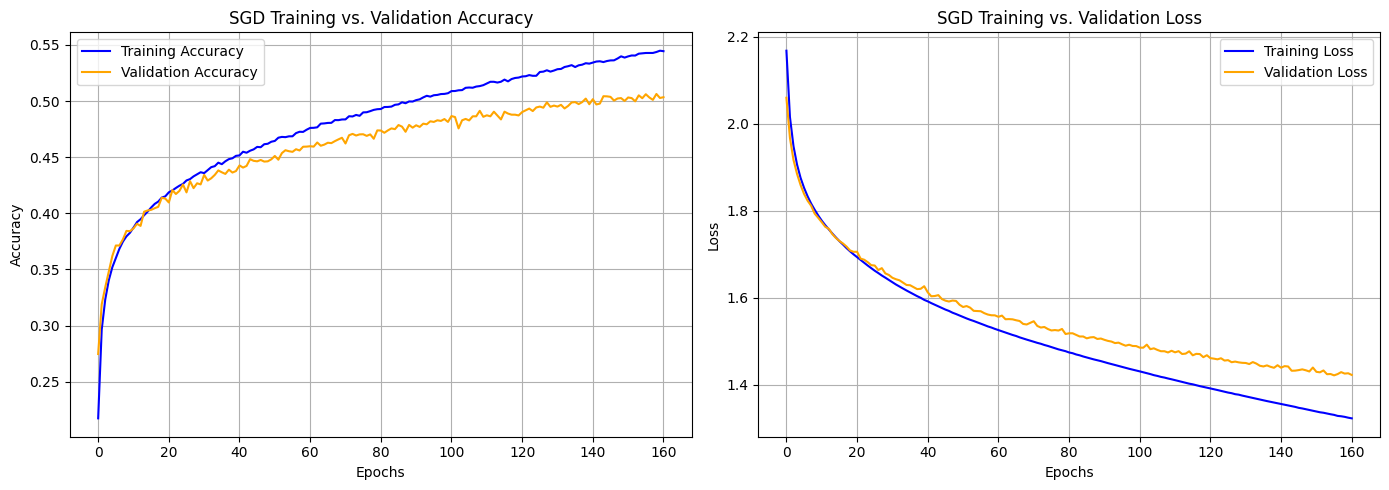

In [ ]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training vs. Validation Accuracy
axes[0].plot(SGD_history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0].plot(SGD_history.history['val_accuracy'], label='Validation Accuracy', color='orange')
axes[0].set_title('SGD Training vs. Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# Plot Training vs. Validation Loss
axes[1].plot(SGD_history.history['loss'], label='Training Loss', color='blue')
axes[1].plot(SGD_history.history['val_loss'], label='Validation Loss', color='orange')
axes[1].set_title('SGD Training vs. Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

# Adjust layout and show plots
plt.tight_layout()
plt.show()



## Evaluate the model

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model_SGD.evaluate(TestingImages, TestingLabels, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4868 - loss: 1.4649
Test Loss: 1.4604
Test Accuracy: 48.77%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


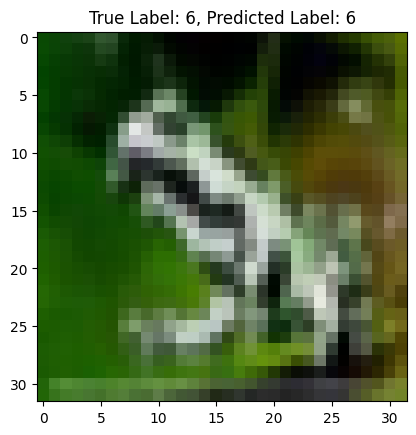

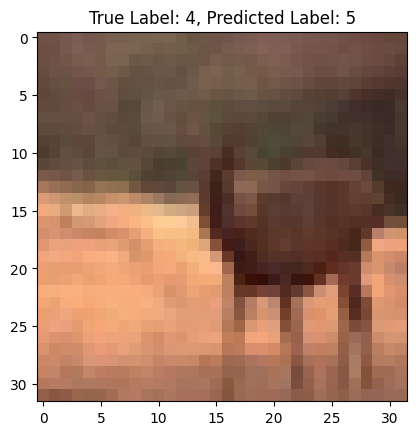

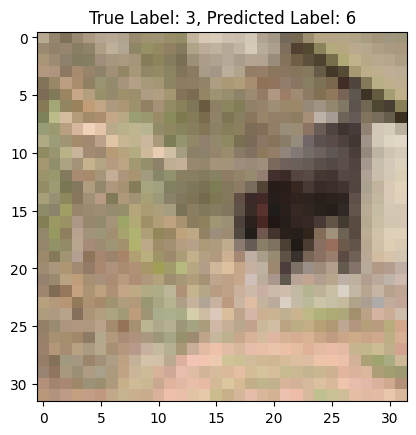

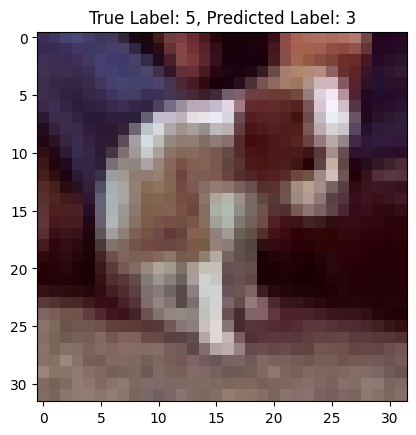

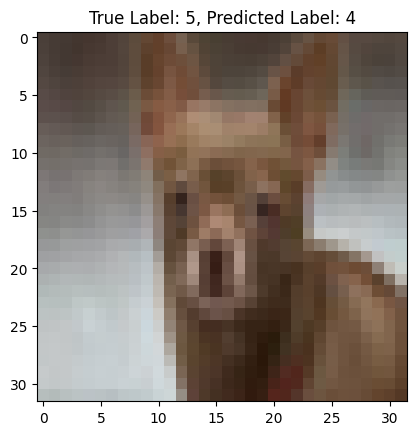

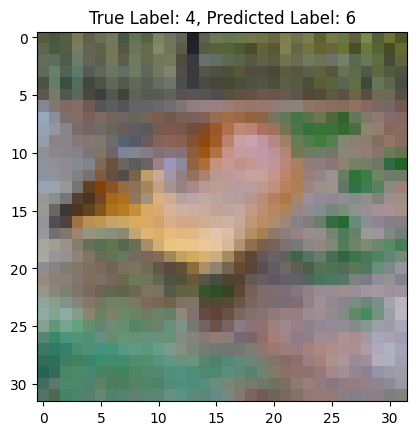

In [ ]:
# Generate predictions for a few samples
num_samples = 6 # Number of test samples to visualize
predictions = model_SGD.predict(TestingImages[:num_samples])

for i in range(num_samples):
    # Get the true label and predicted label
    true_label = np.argmax(TestingLabels[i])  # The true label is the index of 1 in the one-hot vector
    predicted_label = np.argmax(predictions[i])  # The predicted label is the index of the max predicted probability

    # Display the image
    plt.imshow(TestingImages[i])
    plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    plt.show()

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


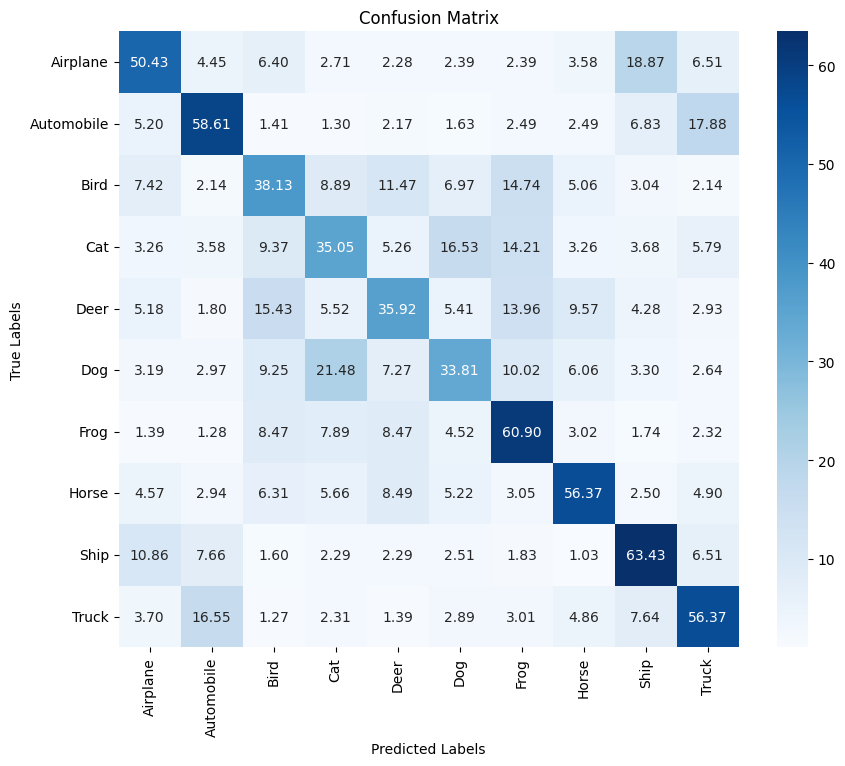

In [ ]:
# Plot the Confusion Matrix
PlotConfusionMatrix(model_SGD)

# Nesterov Accelerated Gradient

### Buliding the model

In [ ]:
# Step 1: Build the model
modelNAG = Sequential([
    Input(shape=(32, 32, 3)),  # Use Input layer to specify the input shape
    Flatten(),                 # Flatten the 32x32x3 images to 1D vector
    Dense(265, activation='relu'),  # Fully connected layer with 128 neurons
    Dense(10, activation='softmax') # Output layer with 10 classes
])

In [ ]:
# Compile the model with NAG optimizer
NAG_Optimizer = SGD(learning_rate=0.001, momentum=0.75, nesterov=True)  # Enabling NAG
modelNAG.compile(optimizer=NAG_Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print("Model compiled with NAG optimizer.")

Model compiled with NAG optimizer.


### Training the model

In [ ]:
# Train the model
import time

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Measure training time
StartTime = time.time()

history = modelNAG.fit(
    TrainingImages, TrainingLabels,
    epochs=300,  # Number of epochs
    batch_size=64,  # Batch size
    validation_data=(ValidationImages, ValidationLabels),  # Validation set
    callbacks=[early_stopping],
    verbose=1  # Show training progress
)

EndTime = time.time()

# Calculate training time
TrainingTime = EndTime - StartTime
print(f"Training time with NAG optimizer: {TrainingTime:.2f} seconds")

Epoch 1/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2300 - loss: 2.1239 - val_accuracy: 0.3289 - val_loss: 1.9033
Epoch 2/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3464 - loss: 1.8767 - val_accuracy: 0.3637 - val_loss: 1.8258
Epoch 3/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3718 - loss: 1.8136 - val_accuracy: 0.3751 - val_loss: 1.7833
Epoch 4/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3895 - loss: 1.7704 - val_accuracy: 0.3857 - val_loss: 1.7620
Epoch 5/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3997 - loss: 1.7303 - val_accuracy: 0.4000 - val_loss: 1.7309
Epoch 6/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4144 - loss: 1.7029 - val_accuracy: 0.4178 - val_loss: 1.7001
Epoch 7/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4176 - loss: 1.6809 - val_accuracy: 0.4194 - val_loss: 1.6799
Epoch 8/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4275 - loss: 1.6585 - val_accu

### Outputs visualization

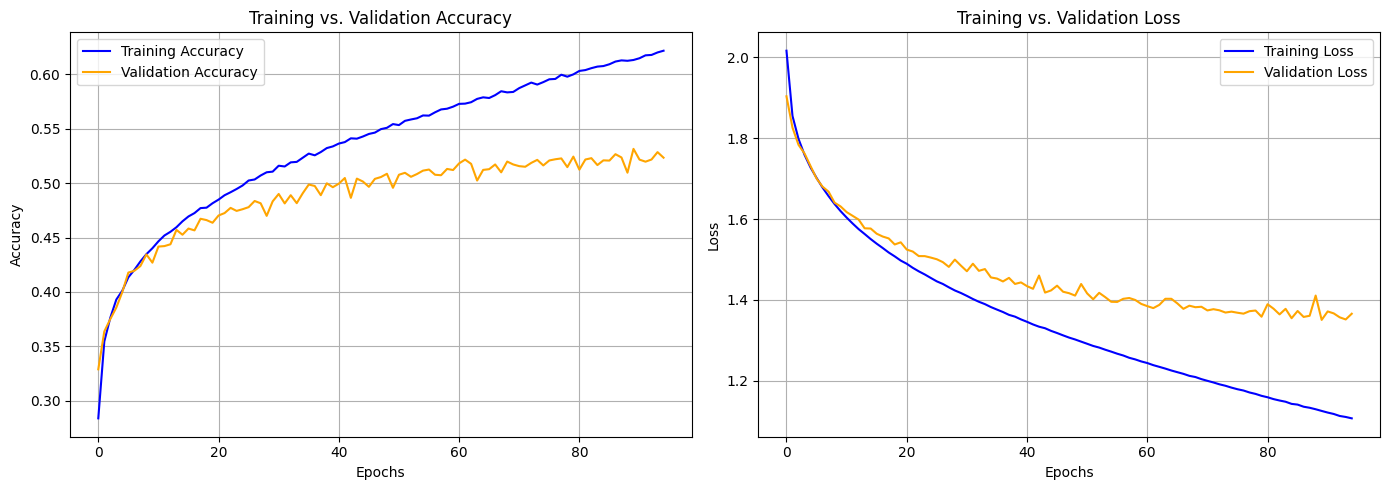

In [ ]:
# Plot training vs validation loss/accuracy to analyze the model's behavior


# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training vs. Validation Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
axes[0].set_title('Training vs. Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# Plot Training vs. Validation Loss
axes[1].plot(history.history['loss'], label='Training Loss', color='blue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axes[1].set_title('Training vs. Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

# Adjust layout and show plots
plt.tight_layout()
plt.show()


### Evaluating the model

In [ ]:
test_loss, test_acc = modelNAG.evaluate(TestingImages, TestingLabels, verbose=1)


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5115 - loss: 1.3950


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


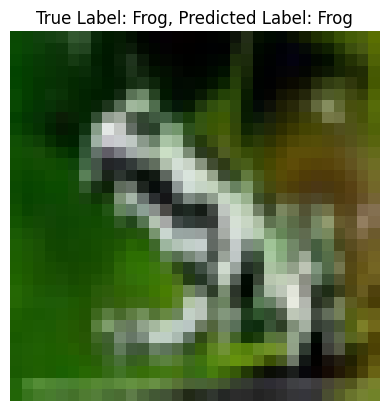

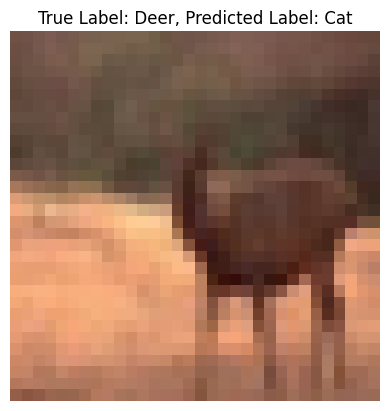

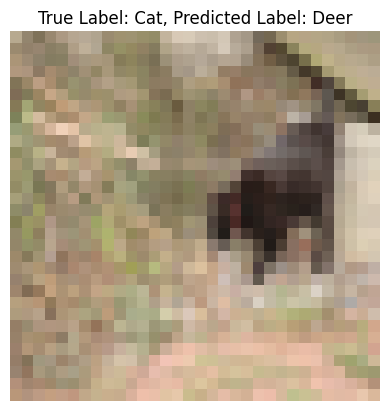

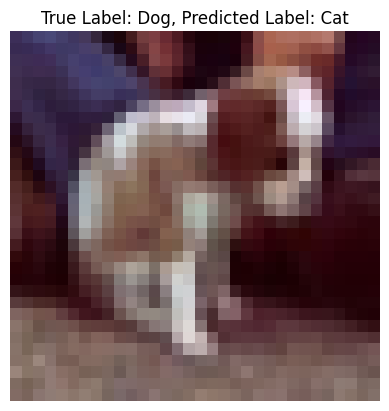

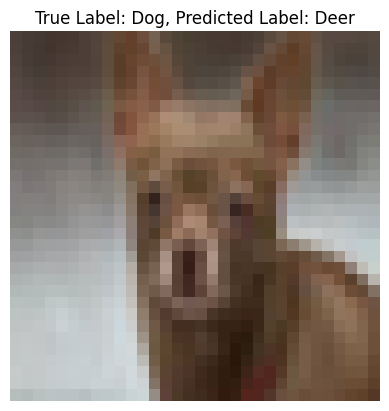

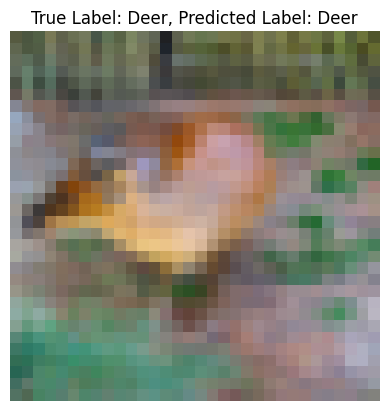

In [ ]:
# Display Image, True Label, and Predicted Label from the test set

samples = 6
predictions = modelNAG.predict(TestingImages[:samples])
PrintTestSamples(TestingImages, TestingLabels, predictions, samples)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


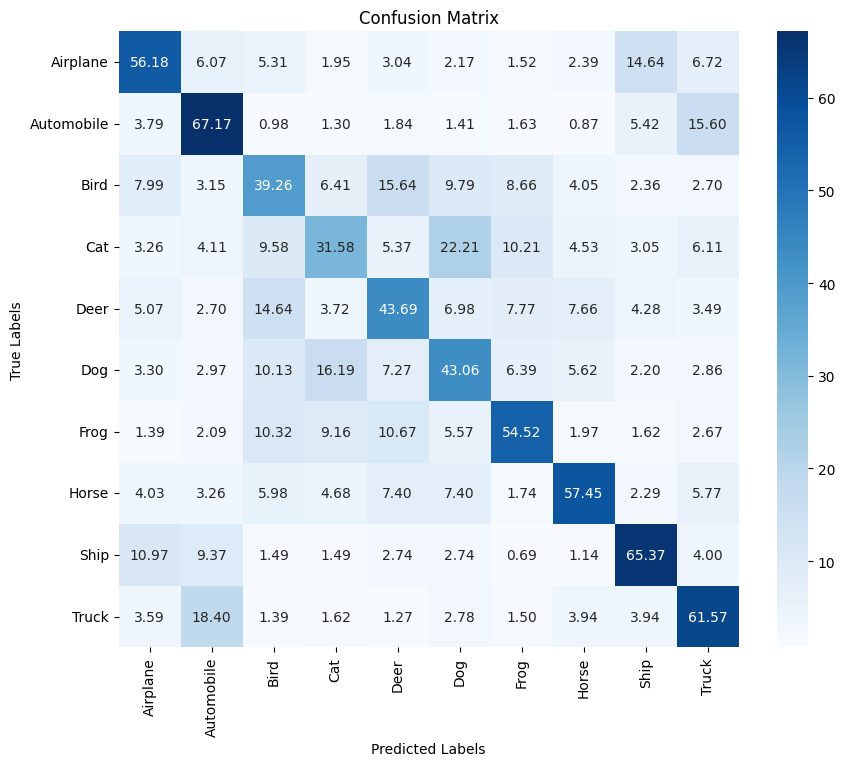

In [ ]:
# Generate predictions
PlotConfusionMatrix(modelNAG)

# RMSProp

## Build and compile the model:

In [ ]:
#Set the parameters:
rsmp_epochs = 500
rsmp_batch_size = 64
rsmp_patience = 10
rsmp_learning_rate = 0.00005
rsmp_rho = 0.9
rsmp_momentum = 0.8
rsmp_epsilon = 1e-07

#Build the model
rmsp_model = Sequential([
    Flatten(input_shape=(32, 32, 3)),  # Flattens images into a 1D array
    Dense(265, activation='relu', name='rmsp_hidden_layer'),
    Dense(10, activation='softmax', name='rmsp_output_layer')  # 10 neurons for 10 classes
])

RMS_optimizer = RMSprop(
    learning_rate=rsmp_learning_rate,
    rho=rsmp_rho,
    momentum=rsmp_momentum,
    epsilon=rsmp_epsilon           #To avoid division by zero
)

#Compile
rmsp_model.compile(
    optimizer=RMS_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Early stopping:
rsmp_early_stopping = EarlyStopping(monitor='val_loss', patience=rsmp_patience, restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train the model:

In [ ]:
rmsp_start_time = time.time()

# Train the model:
rmsp_history = rmsp_model.fit(
    TrainingImages, TrainingLabels,
    epochs=rsmp_epochs,
    batch_size=rsmp_batch_size,
    validation_data=(ValidationImages, ValidationLabels),
    callbacks=[rsmp_early_stopping]
)

rmsp_end_time = time.time()

# Calculate and print training time:
rmsp_training_time = rmsp_end_time - rmsp_start_time
print(f"RMSProp Training Time: {rmsp_training_time:.2f} seconds")

Epoch 1/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2784 - loss: 2.0048 - val_accuracy: 0.3412 - val_loss: 1.8519
Epoch 2/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3812 - loss: 1.7520 - val_accuracy: 0.3891 - val_loss: 1.7043
Epoch 3/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4118 - loss: 1.6669 - val_accuracy: 0.3978 - val_loss: 1.7047
Epoch 4/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4334 - loss: 1.6113 - val_accuracy: 0.4001 - val_loss: 1.6828
Epoch 5/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4503 - loss: 1.5687 - val_accuracy: 0.4482 - val_loss: 1.5571
Epoch 6/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4612 - loss: 1.5269 - val_accuracy: 0.4546 - val_loss: 1.5668
Epoch 7/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4786 - loss: 1.4868 - val_accuracy: 0.4619 - val_loss: 1.5047
Epoch 8/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4834 - loss: 1.4650 - val_accu

## Evaluate the model:

In [ ]:
rmsp_test_loss, rmsp_test_accuracy = rmsp_model.evaluate(TestingImages, TestingLabels)
print(f"RMSProp Test Loss: {rmsp_test_loss:.4f}")
print(f"RMSProp Test Accuracy: {rmsp_test_accuracy:.4f}")

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5051 - loss: 1.4364
RMSProp Test Loss: 1.4274
RMSProp Test Accuracy: 0.5098


### Plot training and validation accuracy and loss:

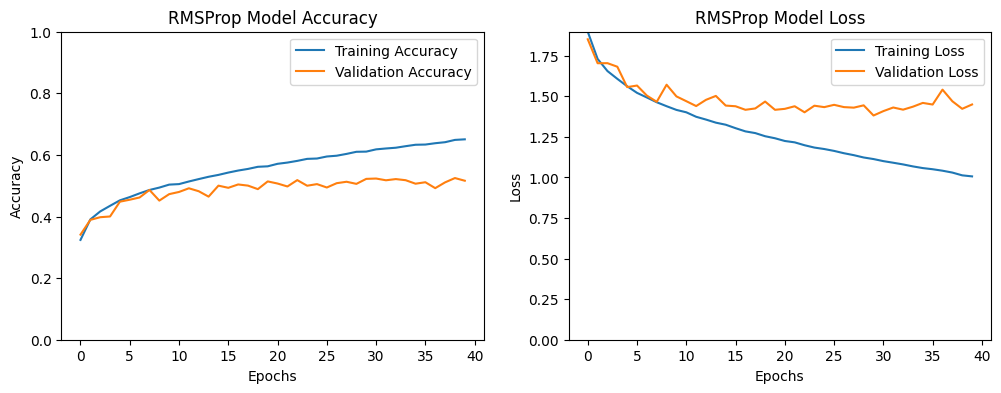

In [ ]:

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(rmsp_history.history['accuracy'], label='Training Accuracy')
plt.plot(rmsp_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RMSProp Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(rmsp_history.history['loss'], label='Training Loss')
plt.plot(rmsp_history.history['val_loss'], label='Validation Loss')
plt.title('RMSProp Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, max(rmsp_history.history['loss'] + rmsp_history.history['val_loss']))

plt.show()

### Print sample imgaes, their true and predicted labels:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


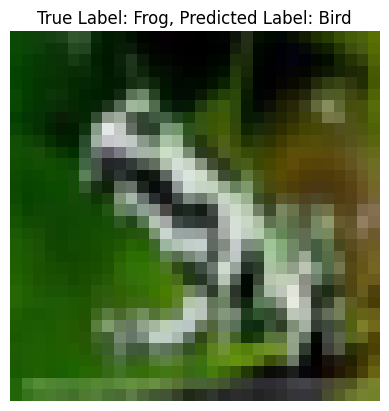

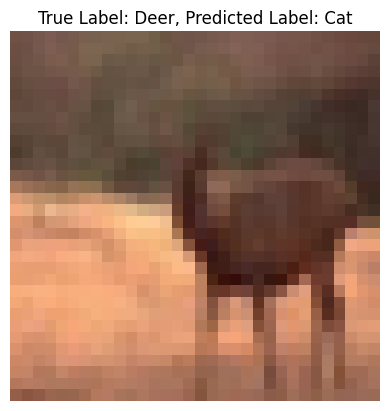

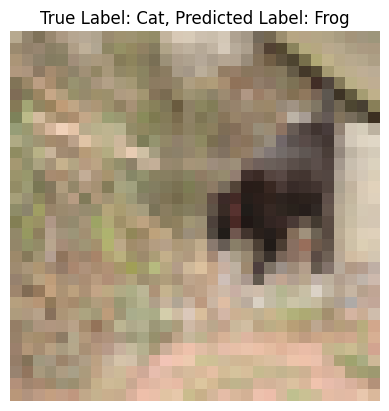

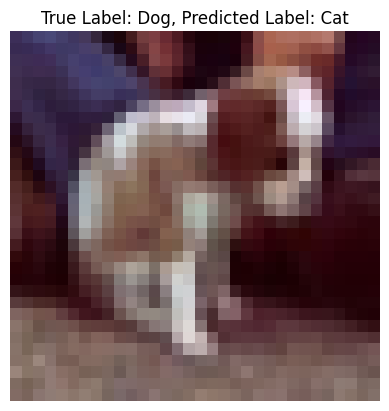

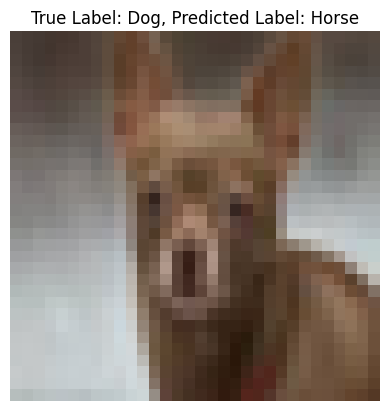

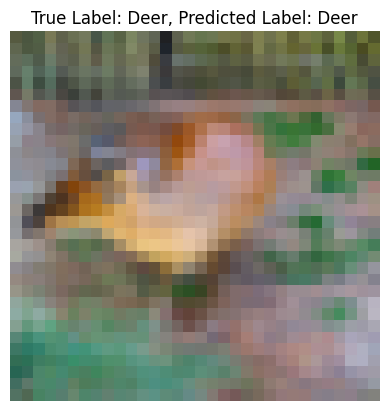

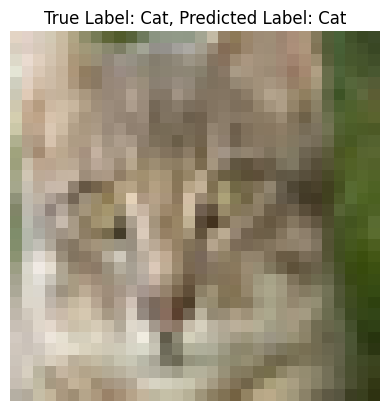

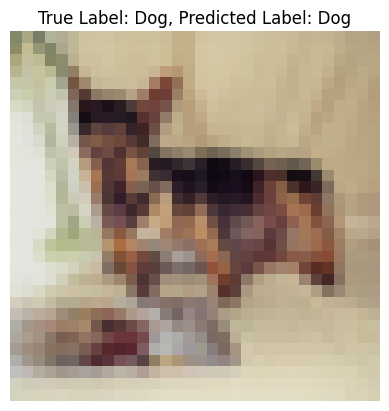

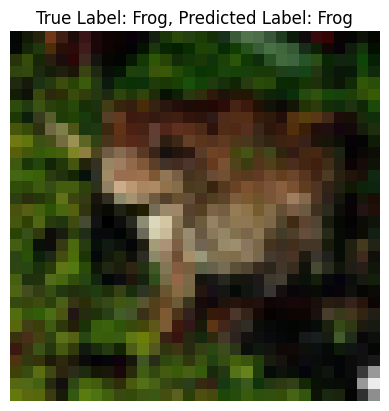

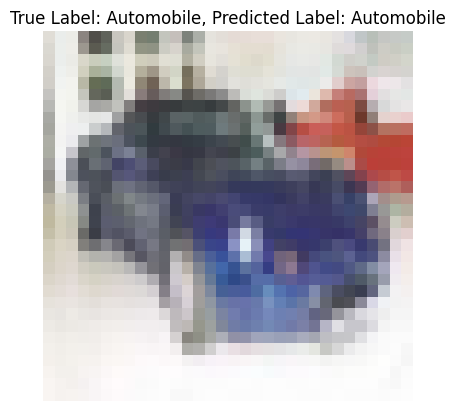

In [ ]:
samples = 10
predictions =  rmsp_model.predict(TestingImages[:samples])
PrintTestSamples(TestingImages, TestingLabels, predictions, samples)


### Confusion Matrix:

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


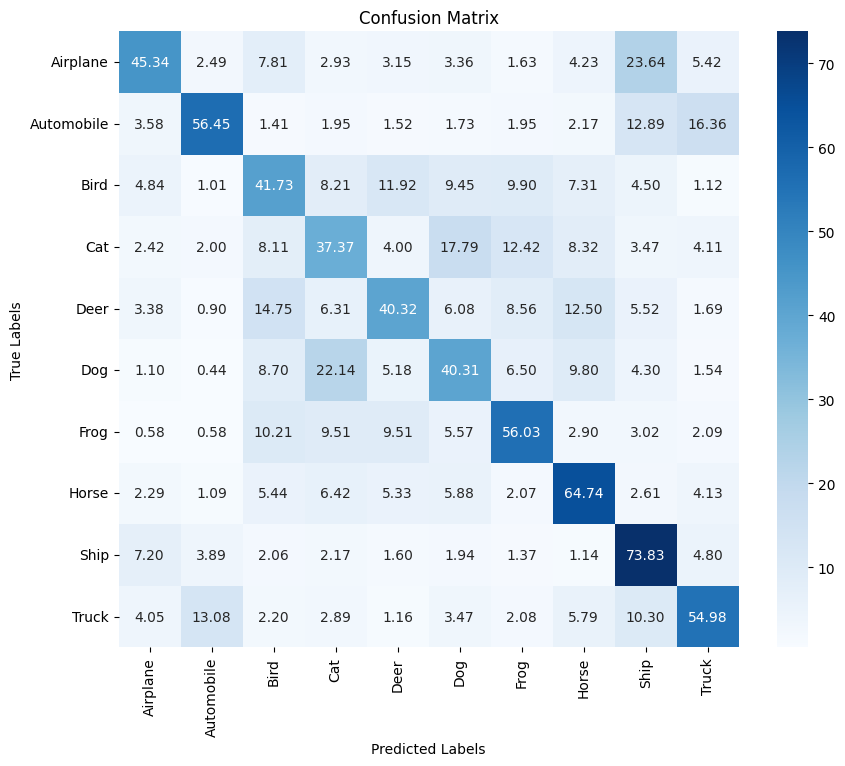

In [ ]:
PlotConfusionMatrix(rmsp_model)

# nadam

## build the model

In [ ]:
# Build the model
model_NADAM = Sequential([
    Input(shape=(32, 32, 3)),     # Input layer for 32x32x3 images
    Flatten(),                   # Flatten the image into a 1D vector
    Dense(265, activation='relu'), # Hidden layer with 256 neurons
    Dense(10, activation='softmax') # Output layer with 10 classes for classification
])

In [ ]:
# Define the NADAM optimizer
NADAM_optimizer = Nadam(learning_rate=0.0001,)  # Nadam optimizer

# Compile the model with NADAM optimizer
model_NADAM.compile(optimizer=NADAM_optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

## train the model

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and measure the training time
NADAM_start_time = time.time()

NADAM_history = model_NADAM.fit(
    TrainingImages, TrainingLabels,
    epochs=300,  # Number of epochs
    batch_size=64,  # Batch size
    validation_data=(ValidationImages, ValidationLabels),  # Validation set
    callbacks=[early_stopping],
    verbose=1  # Show training progress
)
NADAM_end_time = time.time()

# Calculate training time
NADAM_training_time = NADAM_end_time - NADAM_start_time
print(f"Training time with NADAM optimizer: {NADAM_training_time:.2f} seconds")

Epoch 1/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2889 - loss: 1.9855 - val_accuracy: 0.3781 - val_loss: 1.7804
Epoch 2/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3926 - loss: 1.7443 - val_accuracy: 0.4142 - val_loss: 1.6721
Epoch 3/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4225 - loss: 1.6608 - val_accuracy: 0.4276 - val_loss: 1.6297
Epoch 4/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4442 - loss: 1.5926 - val_accuracy: 0.4464 - val_loss: 1.5869
Epoch 5/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4558 - loss: 1.5698 - val_accuracy: 0.4419 - val_loss: 1.5880
Epoch 6/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4672 - loss: 1.5264 - val_accuracy: 0.4690 - val_loss: 1.5474
Epoch 7/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4794 - loss: 1.5053 - val_accuracy: 0.4661 - val_loss: 1.5311
Epoch 8/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4902 - loss: 1.4741 - val_accu

## plotting outputs

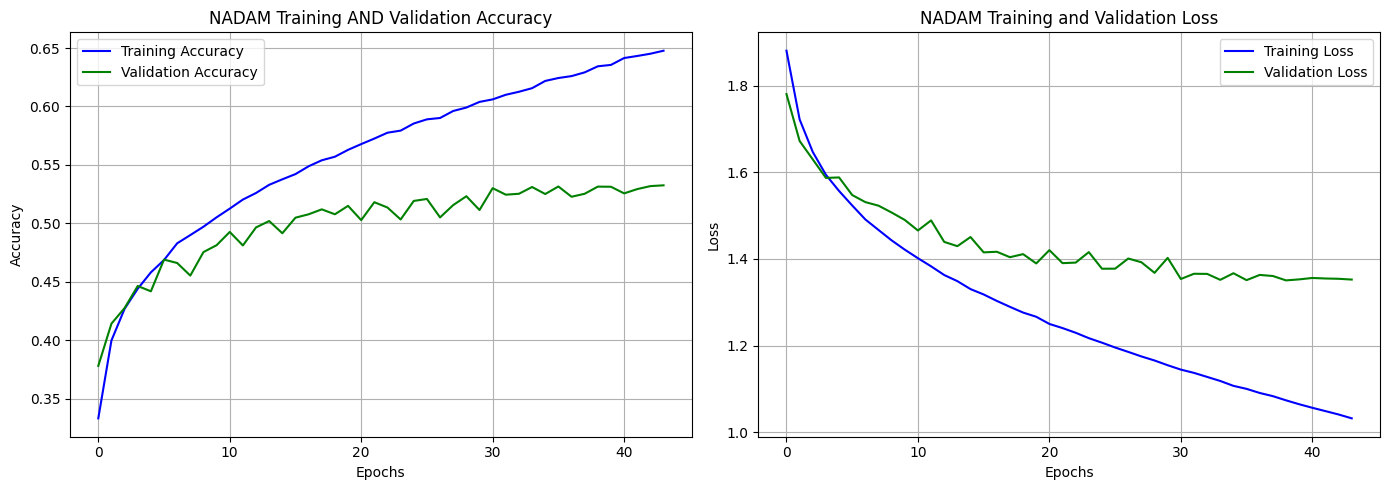

In [ ]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training vs. Validation Accuracy
axes[0].plot(NADAM_history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0].plot(NADAM_history.history['val_accuracy'], label='Validation Accuracy', color='green')
axes[0].set_title('NADAM Training AND Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# Plot Training vs. Validation Loss
axes[1].plot(NADAM_history.history['loss'], label='Training Loss', color='blue')
axes[1].plot(NADAM_history.history['val_loss'], label='Validation Loss', color='green')
axes[1].set_title('NADAM Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

# Adjust layout and show plots
plt.tight_layout()
plt.show()

## EVALUATE

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model_NADAM.evaluate(TestingImages, TestingLabels, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5228 - loss: 1.3899
Test Loss: 1.3888
Test Accuracy: 52.23%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


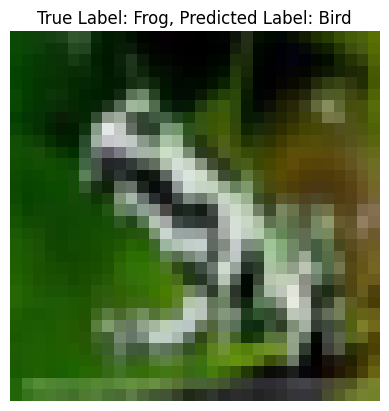

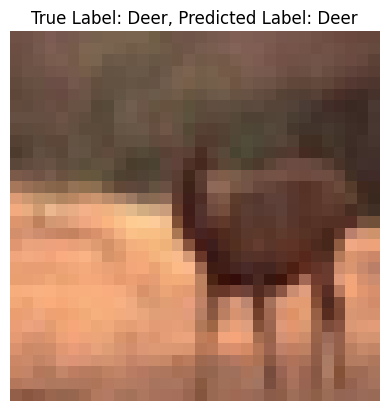

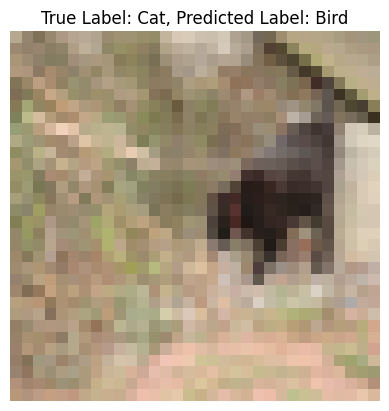

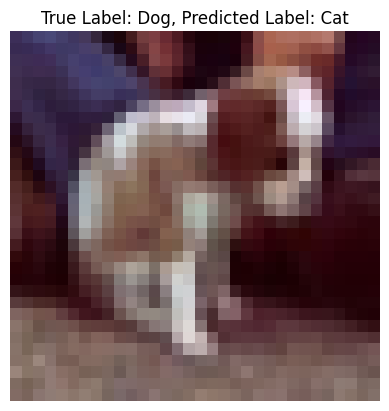

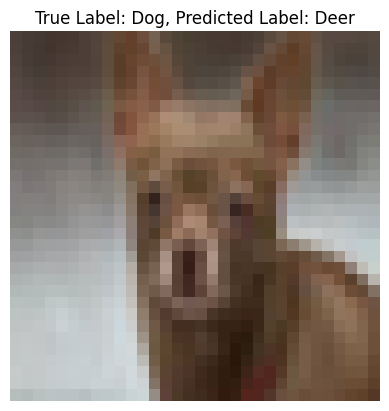

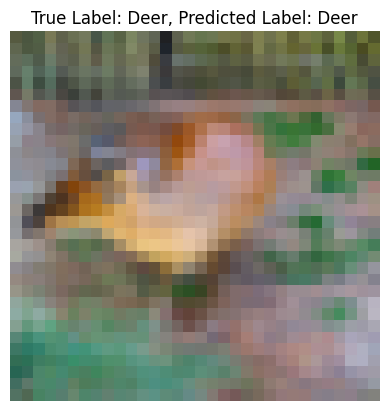

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


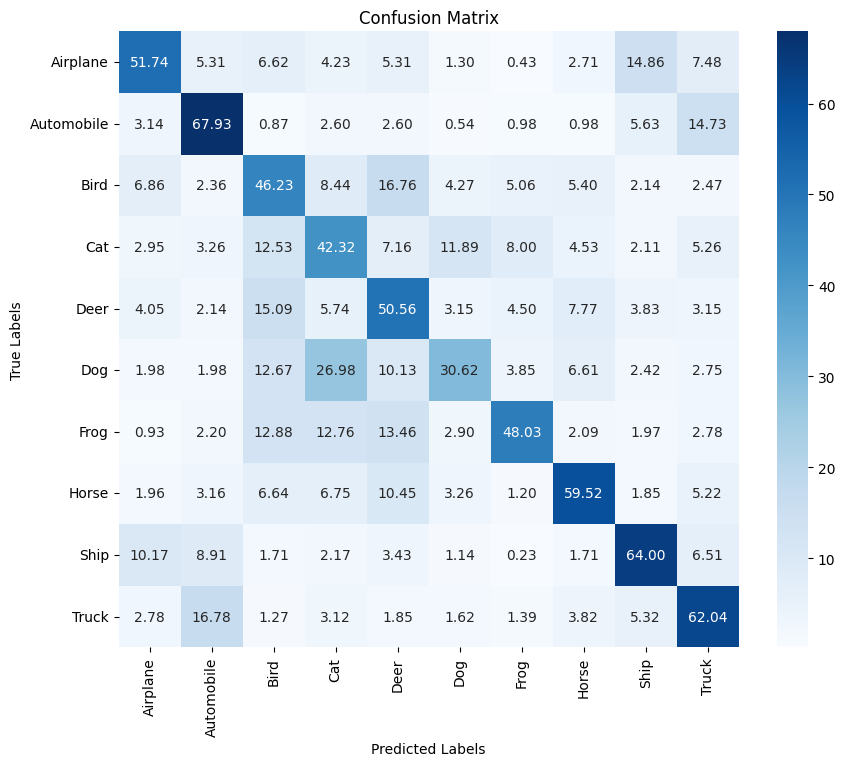

In [ ]:
num_samples = 6 # Number of test samples to visualize
predictions = model_NADAM.predict(TestingImages[:num_samples])
PrintTestSamples(TestingImages, TestingLabels, predictions, num_samples)

PlotConfusionMatrix(model_NADAM)

# Learning Rate Schedulers

## Exponential Decay

In [ ]:
def ExpDecay(epoch, lr):
    decay_rate = 0.1  # You can experiment with this value
    initial_lr = 0.001  # Your initial learning rate
    new_lr = initial_lr * np.exp(-decay_rate * epoch)
    return new_lr

exp_lr_scheduler = LearningRateScheduler(ExpDecay)

### NAG

In [ ]:
# Step 1: Build the model
modelNAG_LrSched = Sequential([
    Input(shape=(32, 32, 3)),  # Use Input layer to specify the input shape
    Flatten(),                 # Flatten the 32x32x3 images to 1D vector
    Dense(265, activation='relu'),  # Fully connected layer with 128 neurons
    Dense(10, activation='softmax') # Output layer with 10 classes
])

# Compile the model with NAG optimizer
NAG_lr_Optimizer = SGD(learning_rate=0.001, momentum=0.75, nesterov=True)  # Enabling NAG
modelNAG_LrSched.compile(optimizer=NAG_lr_Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print("Model compiled with NAG optimizer.")

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Measure training time


Model compiled with NAG optimizer.


In [ ]:
StartTime = time.time()

history = modelNAG_LrSched.fit(
    TrainingImages, TrainingLabels,
    epochs=300,  # Number of epochs
    batch_size=64,  # Batch size
    validation_data=(ValidationImages, ValidationLabels),  # Validation set
    callbacks=[early_stopping, exp_lr_scheduler],
    verbose=1  # Show training progress
)

EndTime = time.time()

# Calculate training time
TrainingTime = EndTime - StartTime
print(f"Training time with NAG optimizer: {TrainingTime:.2f} seconds")

Epoch 1/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2398 - loss: 2.1159 - val_accuracy: 0.3322 - val_loss: 1.8872 - learning_rate: 0.0010
Epoch 2/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3487 - loss: 1.8688 - val_accuracy: 0.3660 - val_loss: 1.8167 - learning_rate: 9.0484e-04
Epoch 3/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3753 - loss: 1.8088 - val_accuracy: 0.3797 - val_loss: 1.7833 - learning_rate: 8.1873e-04
Epoch 4/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3897 - loss: 1.7660 - val_accuracy: 0.3928 - val_loss: 1.7503 - learning_rate: 7.4082e-04
Epoch 5/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3976 - loss: 1.7437 - val_accuracy: 0.3970 - val_loss: 1.7402 - learning_rate: 6.7032e-04
Epoch 6/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4030 - loss: 1.7250 - val_accuracy: 0.4062 - val_loss: 1.7175 - learning_rate: 6.0653e-04
Epoch 7/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accurac

#### Outputs visualization

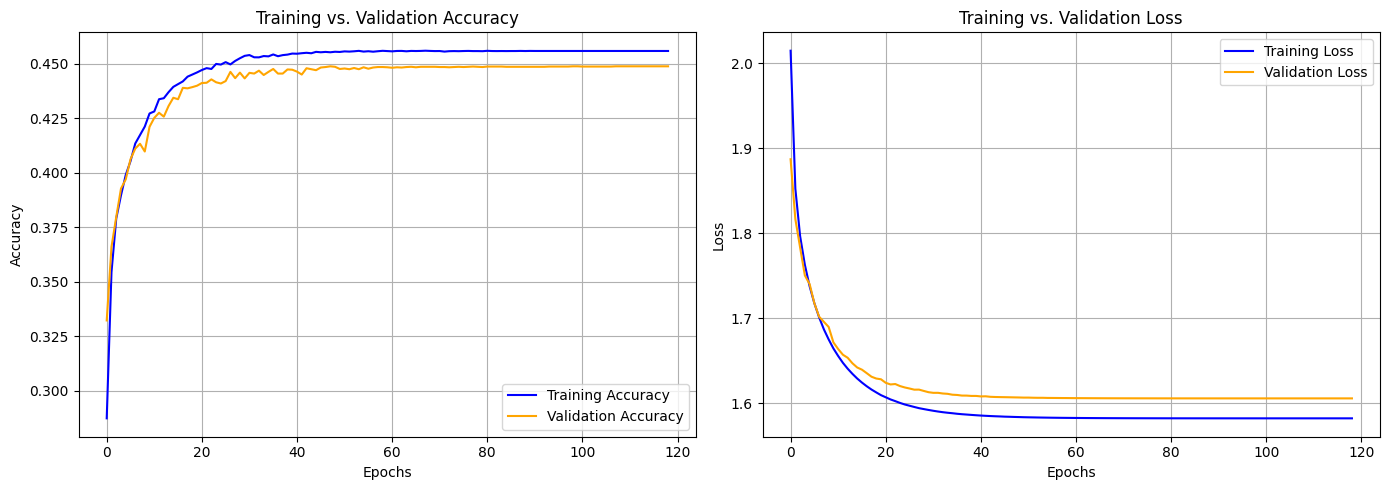

In [ ]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training vs. Validation Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
axes[0].set_title('Training vs. Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# Plot Training vs. Validation Loss
axes[1].plot(history.history['loss'], label='Training Loss', color='blue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axes[1].set_title('Training vs. Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

# Adjust layout and show plots
plt.tight_layout()
plt.show()


#### Evaluating the model

In [ ]:
test_loss, test_acc = modelNAG_LrSched.evaluate(TestingImages, TestingLabels, verbose=1)


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4275 - loss: 1.6337


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


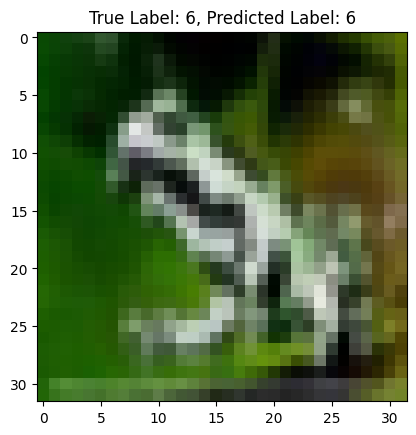

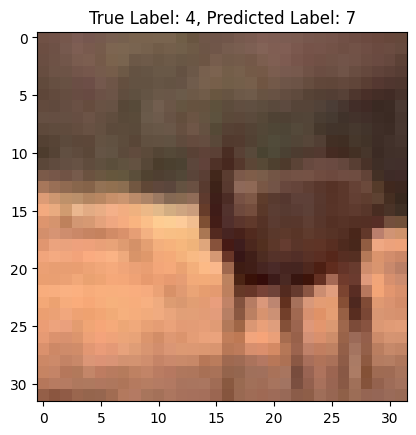

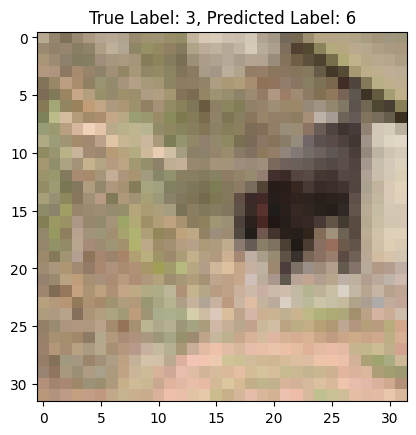

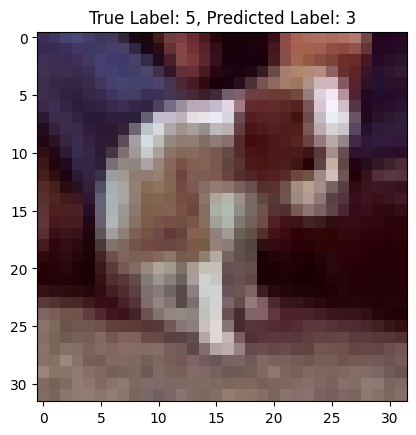

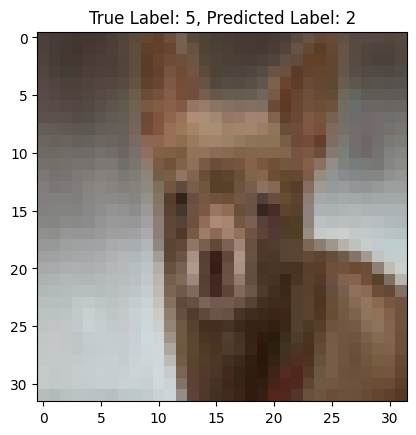

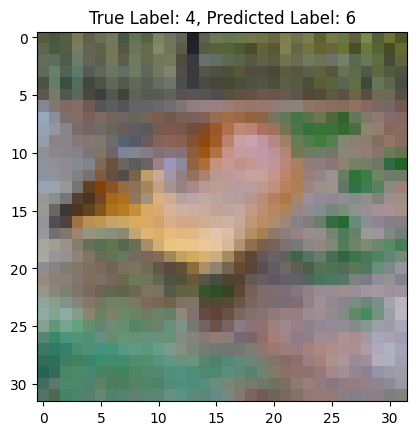

In [ ]:
# Display Image, True Label, and Predicted Label from the test set
num_samples = 6  # Number of samples to display
predictions = modelNAG_LrSched.predict(TestingImages[:num_samples])

for i in range(num_samples):
    # Get the true label and predicted label
    true_label = np.argmax(TestingLabels[i])  # The true label is the index of 1 in the one-hot vector
    predicted_label = np.argmax(predictions[i])  # The predicted label is the index of the max predicted probability

    # Display the image
    plt.imshow(TestingImages[i])
    plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    plt.show()

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


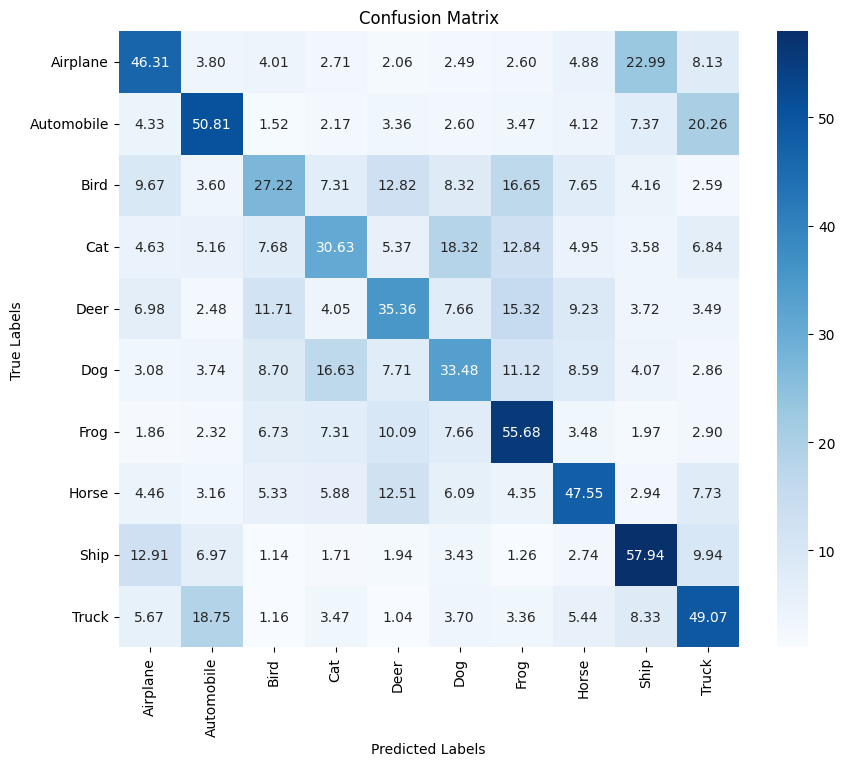

In [ ]:
from sklearn.metrics import confusion_matrix
# Generate predictions
PlotConfusionMatrix(modelNAG_LrSched)



### RMSProp

In [ ]:
#Set the parameters:
rsmp_exp_epochs = 500
rsmp_exp_batch_size = 64
rsmp_exp_patience = 10
rsmp_exp_learning_rate = 0.00005
rsmp_exp_rho = 0.9
rsmp_exp_momentum = 0.8
rsmp_exp_epsilon = 1e-07

#Build the model
rmsp_exp_model = Sequential([
    Flatten(input_shape=(32, 32, 3)),  # Flattens images into a 1D array
    Dense(265, activation='relu', name='rmsp_hidden_layer'),
    Dense(10, activation='softmax', name='rmsp_output_layer')  # 10 neurons for 10 classes
])

RMS_optimizer = RMSprop(
    learning_rate=rsmp_learning_rate,
    rho=rsmp_rho,
    momentum=rsmp_momentum,
    epsilon=rsmp_epsilon           #To avoid division by zero
)

#Compile
rmsp_exp_model.compile(
    optimizer=RMS_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Early stopping:
rsmp_exp_early_stopping = EarlyStopping(monitor='val_loss', patience=rsmp_patience, restore_best_weights=True)

rmsp_exp_start_time = time.time()

# Train the model:
rmsp_exp_history = rmsp_exp_model.fit(
    TrainingImages, TrainingLabels,
    epochs=rsmp_exp_epochs,
    batch_size=rsmp_exp_batch_size,
    validation_data=(ValidationImages, ValidationLabels),
    callbacks=[rsmp_exp_early_stopping, exp_lr_scheduler]
)

rmsp_exp_end_time = time.time()

# Calculate and print training time:
rmsp_exp_training_time = rmsp_exp_end_time - rmsp_exp_start_time
print(f"RMSProp Training Time: {rmsp_exp_training_time:.2f} seconds")


Epoch 1/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2344 - loss: 3.7705 - val_accuracy: 0.3256 - val_loss: 1.8737 - learning_rate: 0.0010
Epoch 2/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3435 - loss: 1.8253 - val_accuracy: 0.3153 - val_loss: 1.9561 - learning_rate: 9.0484e-04
Epoch 3/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3617 - loss: 1.7672 - val_accuracy: 0.3646 - val_loss: 1.8036 - learning_rate: 8.1873e-04
Epoch 4/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3808 - loss: 1.7279 - val_accuracy: 0.3776 - val_loss: 1.7068 - learning_rate: 7.4082e-04
Epoch 5/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3894 - loss: 1.7077 - val_accuracy: 0.3826 - val_loss: 1.7144 - learning_rate: 6.7032e-04
Epoch 6/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4026 - loss: 1.6760 - val_accuracy: 0.4167 - val_loss: 1.6400 - learning_rate: 6.0653e-04
Epoch 7/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accurac

#### Evaluation

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4346 - loss: 1.5988
RMSProp Test Loss: 1.6041
RMSProp Test Accuracy: 0.4334


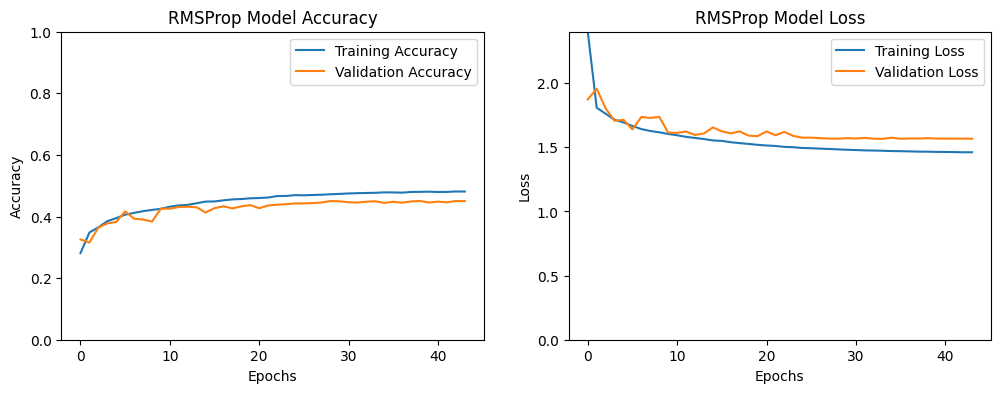

In [ ]:
rmsp_exp_test_loss, rmsp_exp_test_accuracy = rmsp_exp_model.evaluate(TestingImages, TestingLabels)
print(f"RMSProp Test Loss: {rmsp_exp_test_loss:.4f}")
print(f"RMSProp Test Accuracy: {rmsp_exp_test_accuracy:.4f}")


plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(rmsp_exp_history.history['accuracy'], label='Training Accuracy')
plt.plot(rmsp_exp_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RMSProp Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(rmsp_exp_history.history['loss'], label='Training Loss')
plt.plot(rmsp_exp_history.history['val_loss'], label='Validation Loss')
plt.title('RMSProp Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, max(rmsp_exp_history.history['loss'] + rmsp_exp_history.history['val_loss']))

plt.show()


### NADAM with exp decay

build the model

In [ ]:
# Build the model
model_NADAM_exp = Sequential([
    Input(shape=(32, 32, 3)),     # Input layer for 32x32x3 images
    Flatten(),                   # Flatten the image into a 1D vector
    Dense(265, activation='relu'), # Hidden layer with 265 neurons
    Dense(10, activation='softmax') # Output layer with 10 classes for classification
])

# Define the NADAM optimizer
NADAM_exp_optimizer = Nadam(learning_rate=0.001)  # Nadam optimizer

# Compile the model with NADAM optimizer
model_NADAM_exp.compile(
    optimizer=NADAM_exp_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

train model

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start Train the model and measure the training time
NADAM_exp_start_time = time.time()

NADAM_history = model_NADAM_exp.fit(TrainingImages, TrainingLabels,
    epochs=300,  # Number of epochs
    batch_size=64,  # Batch size
    validation_data=(ValidationImages, ValidationLabels),  # Validation set
    callbacks=[early_stopping, exp_lr_scheduler],
    verbose=1  # Show training progress
)
NADAM_exp_end_time = time.time()

# Calculate training time
NADAM_exp_training_time = NADAM_exp_end_time - NADAM_exp_start_time
print(f"Training time with NADAM optimizer: {NADAM_exp_training_time:.2f} seconds")

Epoch 1/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2924 - loss: 2.0230 - val_accuracy: 0.3860 - val_loss: 1.7389 - learning_rate: 0.0010
Epoch 2/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3986 - loss: 1.7125 - val_accuracy: 0.4237 - val_loss: 1.6327 - learning_rate: 9.0484e-04
Epoch 3/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4233 - loss: 1.6318 - val_accuracy: 0.4038 - val_loss: 1.6530 - learning_rate: 8.1873e-04
Epoch 4/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4413 - loss: 1.5756 - val_accuracy: 0.4419 - val_loss: 1.5781 - learning_rate: 7.4082e-04
Epoch 5/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4533 - loss: 1.5362 - val_accuracy: 0.4404 - val_loss: 1.5665 - learning_rate: 6.7032e-04
Epoch 6/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4694 - loss: 1.4970 - val_accuracy: 0.4740 - val_loss: 1.5124 - learning_rate: 6.0653e-04
Epoch 7/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accurac

PLOT OUTPUT

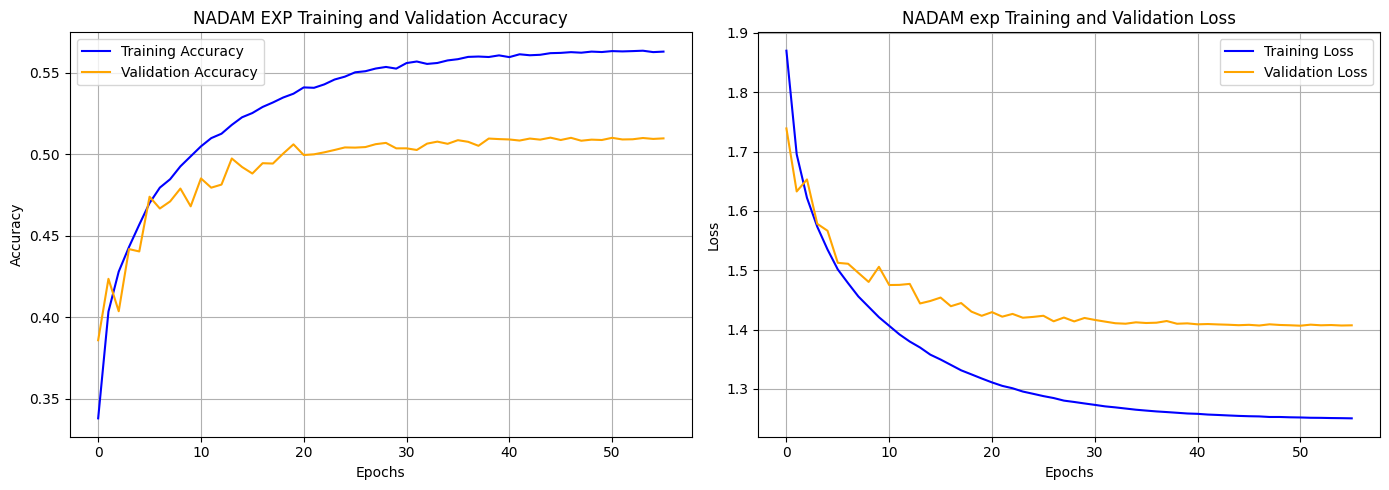

In [ ]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training vs. Validation Accuracy
axes[0].plot(NADAM_history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0].plot(NADAM_history.history['val_accuracy'], label='Validation Accuracy', color='orange')
axes[0].set_title('NADAM EXP Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# Plot Training vs. Validation Loss
axes[1].plot(NADAM_history.history['loss'], label='Training Loss', color='blue')
axes[1].plot(NADAM_history.history['val_loss'], label='Validation Loss', color='orange')
axes[1].set_title('NADAM exp Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

# Adjust layout and show plots
plt.tight_layout()
plt.show()

EVALUATE

In [ ]:
#evaluate the model
test_loss, test_accuracy = model_NADAM_exp.evaluate(TestingImages, TestingLabels, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4865 - loss: 1.4571
Test Loss: 1.4563
Test Accuracy: 49.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


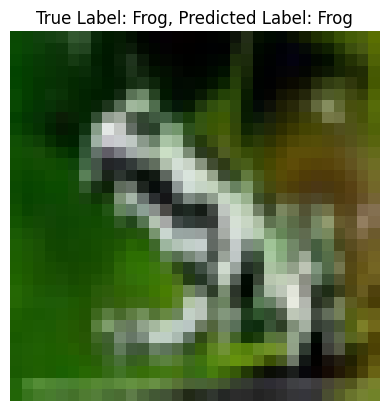

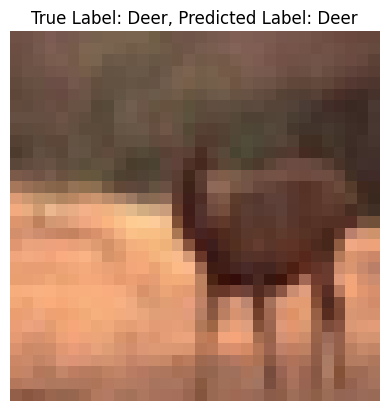

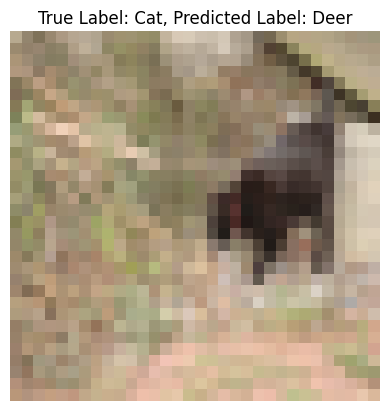

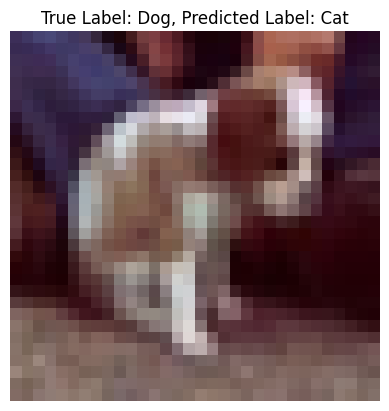

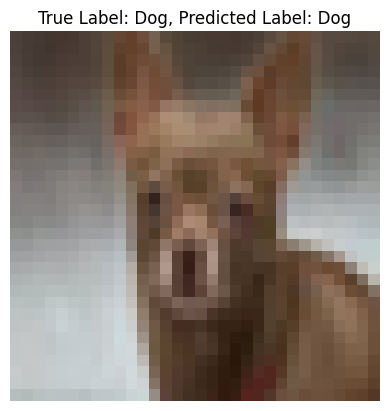

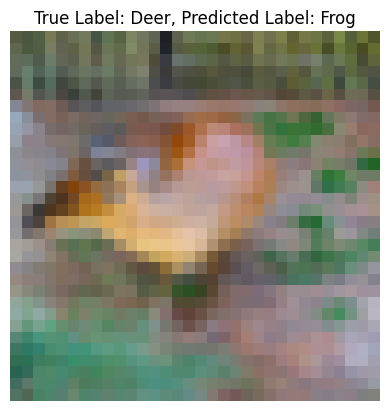

In [ ]:
# Generate predictions for a few samples
num_samples = 6 # Number of test samples to visualize
predictions = model_NADAM_exp.predict(TestingImages[:num_samples])
PrintTestSamples(TestingImages, TestingLabels, predictions, num_samples)


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


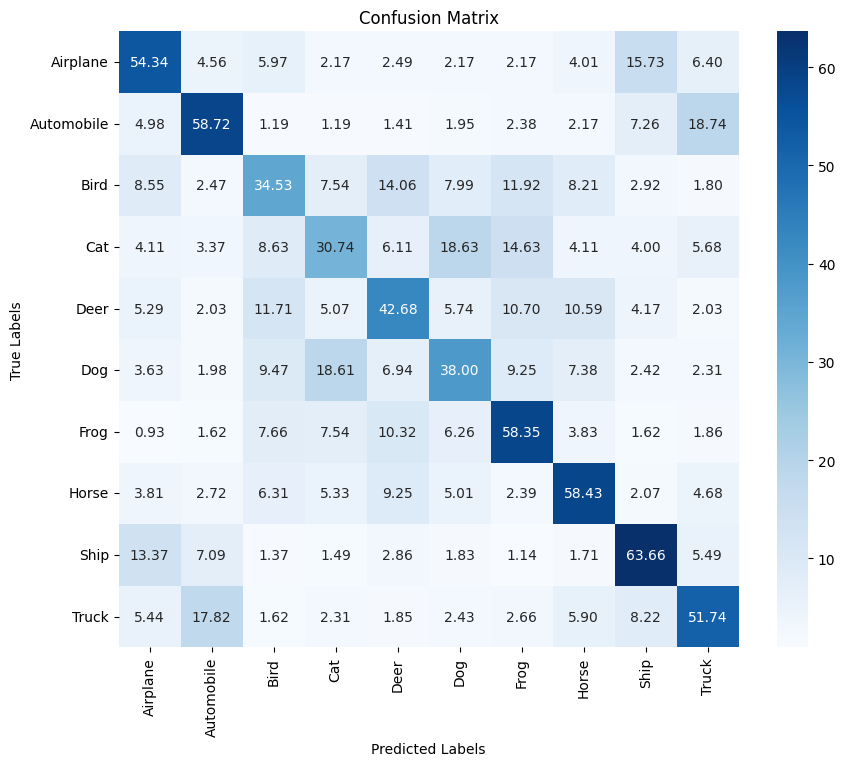

In [ ]:
# Plot the Confusion Matrix
PlotConfusionMatrix(model_NADAM_exp)

## Step Decay

In [ ]:
def StepDecay(epoch, lr):
    initial_lr = 0.001  # Starting learning rate
    drop_factor = 0.5   # Reduce the learning rate by half
    step_size = 10      # Drop every 10 epochs
    new_lr = initial_lr * (drop_factor ** (epoch // step_size))  # Step decay formula
    return new_lr

# Create the Learning Rate Scheduler
step_lr_scheduler = LearningRateScheduler(StepDecay)

### NAG

In [ ]:
# Step 1: Build the model
modelNAG_StepSched = Sequential([
    Input(shape=(32, 32, 3)),  # Use Input layer to specify the input shape
    Flatten(),                 # Flatten the 32x32x3 images to 1D vector
    Dense(265, activation='relu'),  # Fully connected layer with 128 neurons
    Dense(10, activation='softmax') # Output layer with 10 classes
])

# Compile the model with NAG optimizer
NAG_Step_Optimizer = SGD(learning_rate=0.001, momentum=0.75, nesterov=True)  # Enabling NAG
modelNAG_StepSched.compile(optimizer=NAG_Step_Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Measure training time

In [ ]:
StartTime = time.time()

history = modelNAG_StepSched.fit(
    TrainingImages, TrainingLabels,
    epochs=300,  # Number of epochs
    batch_size=64,  # Batch size
    validation_data=(ValidationImages, ValidationLabels),  # Validation set
    callbacks=[early_stopping, step_lr_scheduler],
    verbose=1  # Show training progress
)

EndTime = time.time()

# Calculate training time
TrainingTime = EndTime - StartTime
print(f"Training time with NAG optimizer: {TrainingTime:.2f} seconds")

Epoch 1/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2288 - loss: 2.1244 - val_accuracy: 0.3370 - val_loss: 1.8936 - learning_rate: 0.0010
Epoch 2/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3468 - loss: 1.8715 - val_accuracy: 0.3678 - val_loss: 1.8182 - learning_rate: 0.0010
Epoch 3/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3741 - loss: 1.8018 - val_accuracy: 0.3649 - val_loss: 1.7876 - learning_rate: 0.0010
Epoch 4/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3862 - loss: 1.7659 - val_accuracy: 0.3948 - val_loss: 1.7450 - learning_rate: 0.0010
Epoch 5/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4011 - loss: 1.7288 - val_accuracy: 0.3960 - val_loss: 1.7217 - learning_rate: 0.0010
Epoch 6/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4090 - loss: 1.7048 - val_accuracy: 0.4112 - val_loss: 1.6899 - learning_rate: 0.0010
Epoch 7/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4190 - loss: 1.

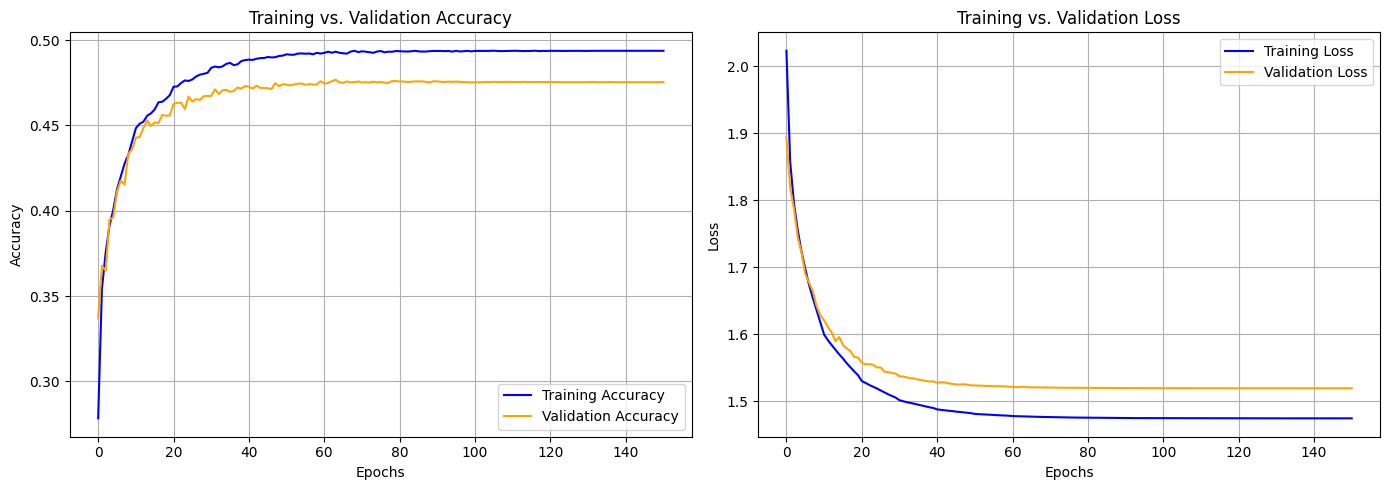

In [ ]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training vs. Validation Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
axes[0].set_title('Training vs. Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# Plot Training vs. Validation Loss
axes[1].plot(history.history['loss'], label='Training Loss', color='blue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axes[1].set_title('Training vs. Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

# Adjust layout and show plots
plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_acc = modelNAG_StepSched.evaluate(TestingImages, TestingLabels, verbose=1)


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4581 - loss: 1.5538


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


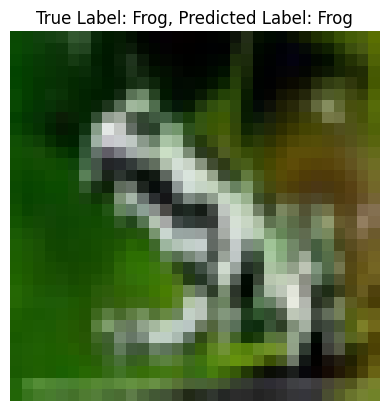

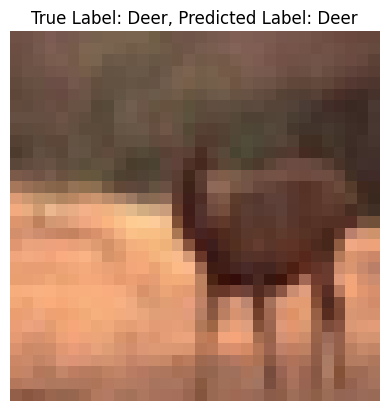

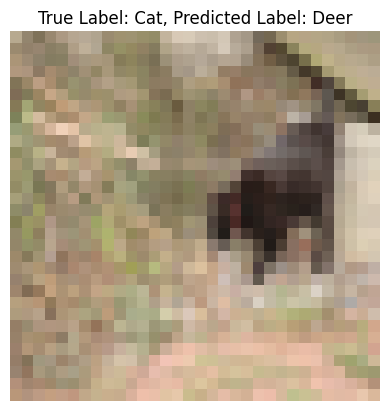

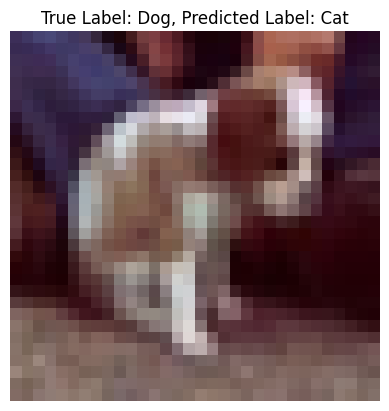

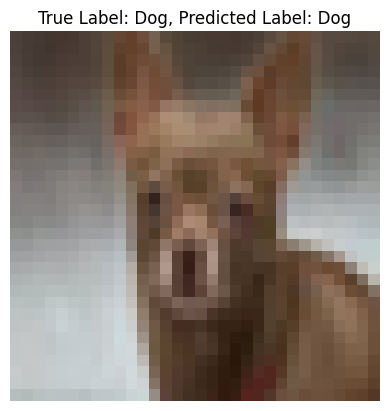

In [ ]:
# Display Image, True Label, and Predicted Label from the test set
predictionsxx = modelNAG_StepSched.predict(TestingImages[:num_samples])

PrintTestSamples(TestingImages, TestingLabels, predictionsxx)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


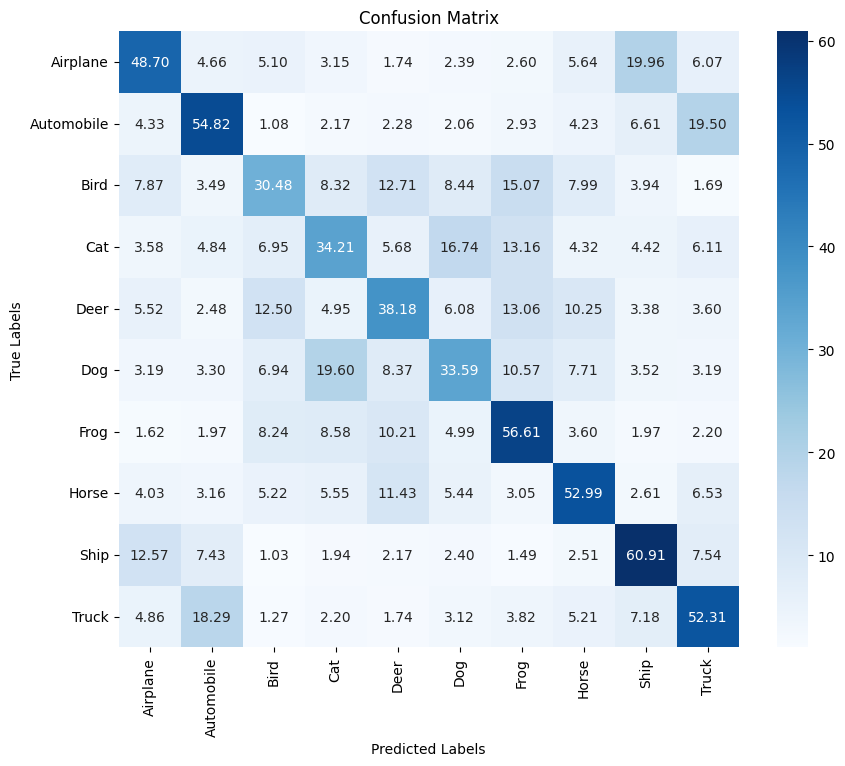

In [ ]:
PlotConfusionMatrix(modelNAG_StepSched)



### RMSProp

In [ ]:
#Set the parameters:
rsmp_step_epochs = 500
rsmp_step_batch_size = 64
rsmp_step_patience = 10
rsmp_step_learning_rate = 0.00005
rsmp_step_rho = 0.9
rsmp_step_momentum = 0.8
rsmp_step_epsilon = 1e-07

#Build the model
rmsp_step_model = Sequential([
    Flatten(input_shape=(32, 32, 3)),  # Flattens images into a 1D array
    Dense(265, activation='relu', name='rmsp_hidden_layer'),
    Dense(10, activation='softmax', name='rmsp_output_layer')  # 10 neurons for 10 classes
])

RMS_optimizer = RMSprop(
    learning_rate=rsmp_learning_rate,
    rho=rsmp_rho,
    momentum=rsmp_momentum,
    epsilon=rsmp_epsilon           #To avoid division by zero
)

#Compile
rmsp_step_model.compile(
    optimizer=RMS_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Early stopping:
rsmp_step_early_stopping = EarlyStopping(monitor='val_loss', patience=rsmp_patience, restore_best_weights=True)

rmsp_step_start_time = time.time()

# Train the model:
rmsp_step_history = rmsp_step_model.fit(
    TrainingImages, TrainingLabels,
    epochs=rsmp_step_epochs,
    batch_size=rsmp_step_batch_size,
    validation_data=(ValidationImages, ValidationLabels),
    callbacks=[rsmp_step_early_stopping, step_lr_scheduler]
)

rmsp_step_end_time = time.time()

# Calculate and print training time:
rmsp_step_training_time = rmsp_step_end_time - rmsp_step_start_time
print(f"RMSProp Training Time: {rmsp_step_training_time:.2f} seconds")


Epoch 1/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2413 - loss: 3.9289 - val_accuracy: 0.3036 - val_loss: 1.9596 - learning_rate: 0.0010
Epoch 2/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3302 - loss: 1.8487 - val_accuracy: 0.3491 - val_loss: 1.7898 - learning_rate: 0.0010
Epoch 3/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3510 - loss: 1.8077 - val_accuracy: 0.3327 - val_loss: 1.8598 - learning_rate: 0.0010
Epoch 4/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3656 - loss: 1.7671 - val_accuracy: 0.3780 - val_loss: 1.7106 - learning_rate: 0.0010
Epoch 5/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3697 - loss: 1.7522 - val_accuracy: 0.3642 - val_loss: 1.7784 - learning_rate: 0.0010
Epoch 6/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3794 - loss: 1.7392 - val_accuracy: 0.3639 - val_loss: 1.7509 - learning_rate: 0.0010
Epoch 7/500
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3790 - loss: 1.

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4052 - loss: 1.6733
RMSProp Test Loss: 1.6711
RMSProp Test Accuracy: 0.4097


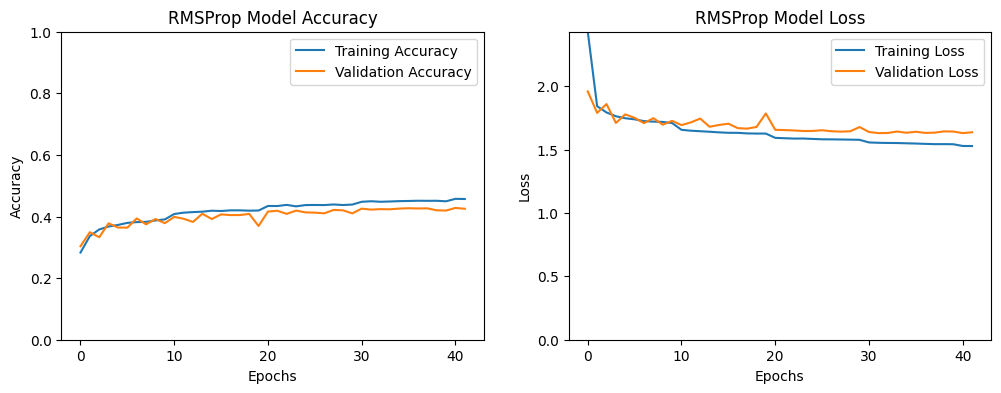

In [ ]:
rmsp_step_test_loss, rmsp_step_test_accuracy = rmsp_step_model.evaluate(TestingImages, TestingLabels)
print(f"RMSProp Test Loss: {rmsp_step_test_loss:.4f}")
print(f"RMSProp Test Accuracy: {rmsp_step_test_accuracy:.4f}")


plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(rmsp_step_history.history['accuracy'], label='Training Accuracy')
plt.plot(rmsp_step_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RMSProp Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(rmsp_step_history.history['loss'], label='Training Loss')
plt.plot(rmsp_step_history.history['val_loss'], label='Validation Loss')
plt.title('RMSProp Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, max(rmsp_step_history.history['loss'] + rmsp_step_history.history['val_loss']))

plt.show()


### NADAM with STEP decay

build model

In [ ]:
# Build the model
model_NADAM_step = Sequential([
    Input(shape=(32, 32, 3)),     # Input layer for 32x32x3 images
    Flatten(),                   # Flatten the image into a 1D vector
    Dense(265, activation='relu'), # Hidden layer with 256 neurons
    Dense(10, activation='softmax') # Output layer with 10 classes for classification
])

In [ ]:
# Define the NADAM optimizer
NADAM_step_optimizer = Nadam(learning_rate=0.001)  # Nadam optimizer

# Compile the model with NADAM optimizer
model_NADAM_step.compile(
    optimizer=NADAM_step_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

train model

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start Train the model and measure the training time
NADAM_step_start_time = time.time()

NADAM_history = model_NADAM_step.fit(TrainingImages, TrainingLabels,
    epochs=300,  # Number of epochs
    batch_size=64,  # Batch size
    validation_data=(ValidationImages, ValidationLabels),  # Validation set
    callbacks=[early_stopping, step_lr_scheduler],
    verbose=1  # Show training progress
)
NADAM_step_end_time = time.time()

# Calculate training time
NADAM_step_training_time = NADAM_step_end_time - NADAM_step_start_time
print(f"Training time with NADAM optimizer: {NADAM_step_training_time:.2f} seconds")

Epoch 1/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2942 - loss: 2.0316 - val_accuracy: 0.3616 - val_loss: 1.7698 - learning_rate: 0.0010
Epoch 2/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3957 - loss: 1.7140 - val_accuracy: 0.4231 - val_loss: 1.6286 - learning_rate: 0.0010
Epoch 3/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4313 - loss: 1.6192 - val_accuracy: 0.4106 - val_loss: 1.6412 - learning_rate: 0.0010
Epoch 4/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4413 - loss: 1.5721 - val_accuracy: 0.4388 - val_loss: 1.5708 - learning_rate: 0.0010
Epoch 5/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4590 - loss: 1.5320 - val_accuracy: 0.4608 - val_loss: 1.5304 - learning_rate: 0.0010
Epoch 6/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4727 - loss: 1.4947 - val_accuracy: 0.4367 - val_loss: 1.5866 - learning_rate: 0.0010
Epoch 7/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4782 - loss: 1.

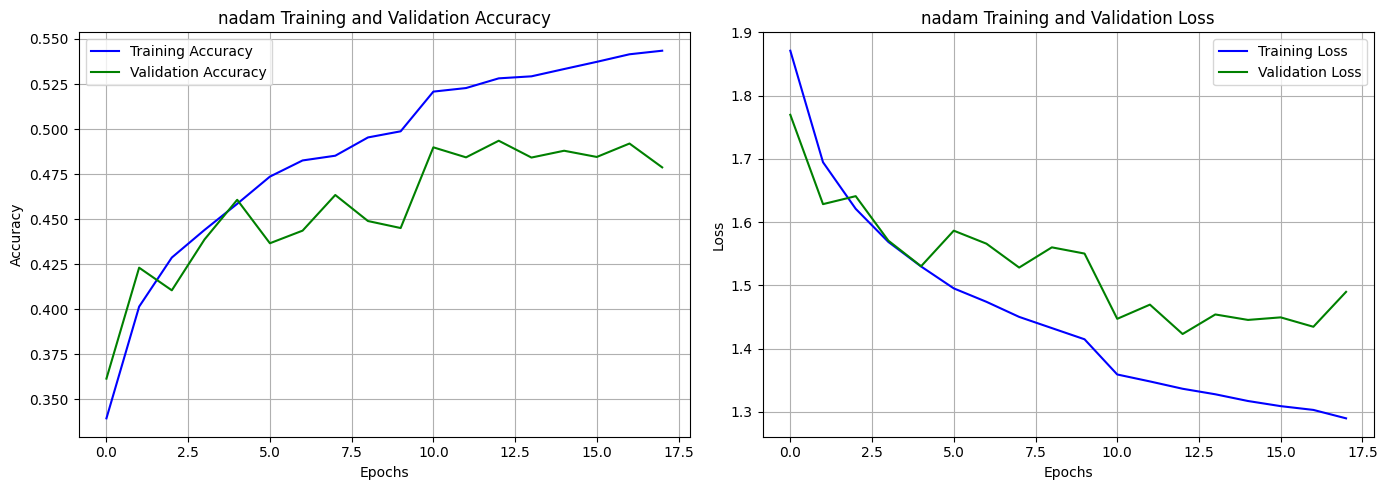

In [ ]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training vs. Validation Accuracy
axes[0].plot(NADAM_history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0].plot(NADAM_history.history['val_accuracy'], label='Validation Accuracy', color='green')
axes[0].set_title('nadam Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# Plot Training vs. Validation Loss
axes[1].plot(NADAM_history.history['loss'], label='Training Loss', color='blue')
axes[1].plot(NADAM_history.history['val_loss'], label='Validation Loss', color='green')
axes[1].set_title('nadam Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

# Adjust layout and show plots
plt.tight_layout()
plt.show()

plot output

evaluate

In [ ]:
# evalute the model
test_loss, test_accuracy = model_NADAM_step.evaluate(TestingImages, TestingLabels, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4807 - loss: 1.4599
Test Loss: 1.4641
Test Accuracy: 48.30%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


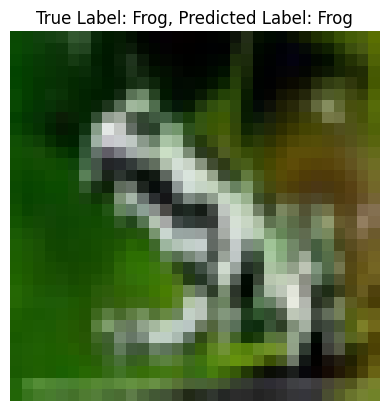

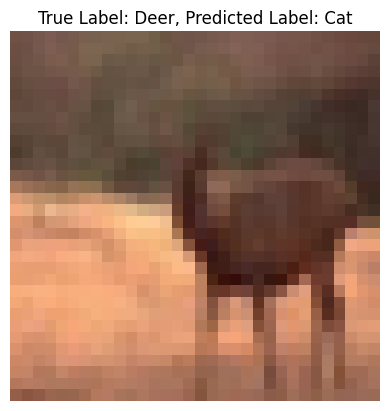

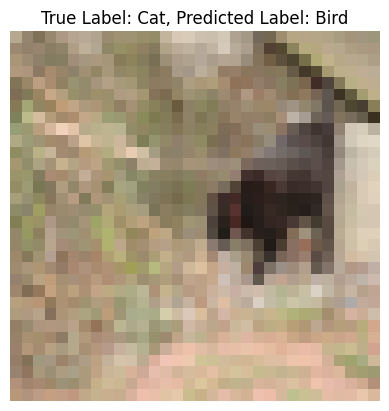

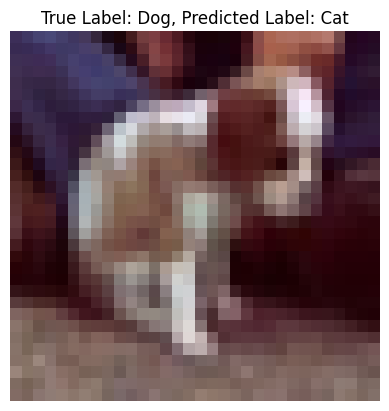

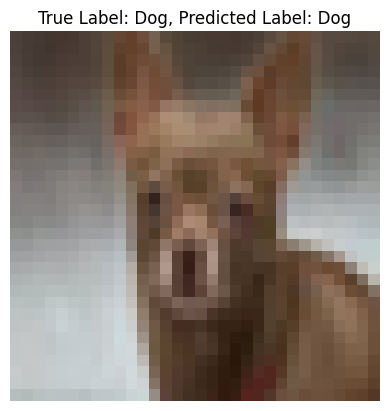

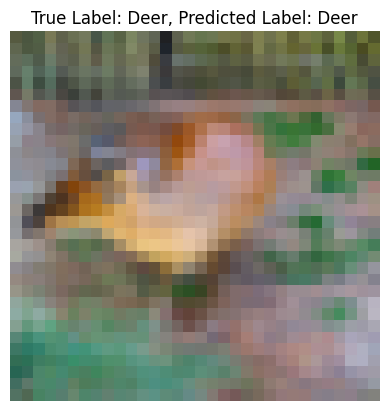

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


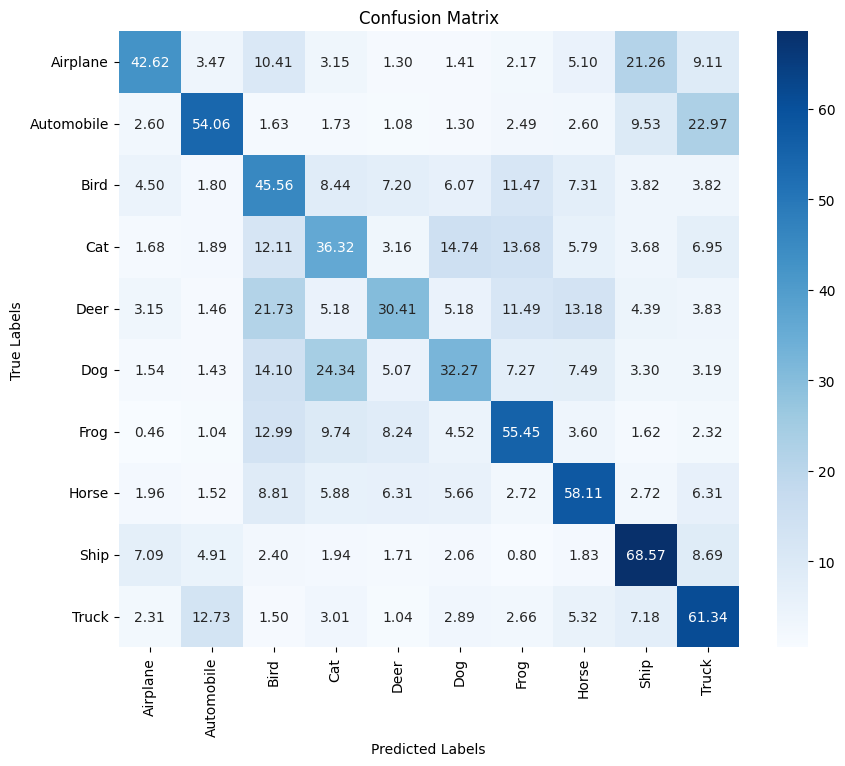

In [ ]:
# Generate predictions for a few samples
num_samples = 6 # Number of test samples to visualize
predictions = model_NADAM_step.predict(TestingImages[:num_samples])
PrintTestSamples(TestingImages, TestingLabels, predictions, num_samples)

# Plot the Confusion Matrix
PlotConfusionMatrix(model_NADAM_step)

## SGD with Warm Restarts:

### Warm Restarts scheduler:

In [ ]:
# Define the learning rate scheduler function for warm restarts
def warm_restart_schedule(epoch, lr):
    initial_lr = 0.001  # Starting learning rate
    T_0 = 10           # Initial period of the cycle
    T_mult = 2         # Factor by which the period increases
    T_cur = epoch % T_0  # Current position in the cycle
    cosine_decay = 0.5 * (1 + math.cos(math.pi * T_cur / T_0))
    new_lr = initial_lr * cosine_decay
    print(f"Epoch {epoch + 1}: Learning rate = {new_lr:.6f}")
    return new_lr

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(warm_restart_schedule)

### Build the model:

In [ ]:
# Define and compile the model
modelSGD_WarmRestarts = Sequential([
    Input(shape=(32, 32, 3)),
    Flatten(),
    Dense(265, activation='relu'),
    Dense(10, activation='softmax')
])

SGD_WarmRestarts_Optimizer = SGD(learning_rate=0.001, momentum=0.9)
modelSGD_WarmRestarts.compile(optimizer=SGD_WarmRestarts_Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


###: Train the model:

In [ ]:
# Measure training time
StartTime = time.time()

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = modelSGD_WarmRestarts.fit(
    TrainingImages, TrainingLabels,
    epochs=300,  # Adjust as needed
    batch_size=64,
    validation_data=(ValidationImages, ValidationLabels),
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

EndTime = time.time()

# Calculate training time
TrainingTime = EndTime - StartTime
print(f"Training time with NAG optimizer: {TrainingTime:.2f} seconds")

Epoch 1: Learning rate = 0.001000
Epoch 1/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2683 - loss: 2.0384 - val_accuracy: 0.3670 - val_loss: 1.8033 - learning_rate: 0.0010
Epoch 2: Learning rate = 0.000976
Epoch 2/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3769 - loss: 1.7851 - val_accuracy: 0.3870 - val_loss: 1.7382 - learning_rate: 9.7553e-04
Epoch 3: Learning rate = 0.000905
Epoch 3/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4011 - loss: 1.7189 - val_accuracy: 0.4172 - val_loss: 1.6766 - learning_rate: 9.0451e-04
Epoch 4: Learning rate = 0.000794
Epoch 4/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4188 - loss: 1.6676 - val_accuracy: 0.4203 - val_loss: 1.6571 - learning_rate: 7.9389e-04
Epoch 5: Learning rate = 0.000655
Epoch 5/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4346 - loss: 1.6228 - val_accuracy: 0.4267 - val_loss: 1.6323 - learning_rate: 6.5451e-04
Epoch 6: Learning rate = 0.000500
Epoch 6/300
657

### Evaluate the model:

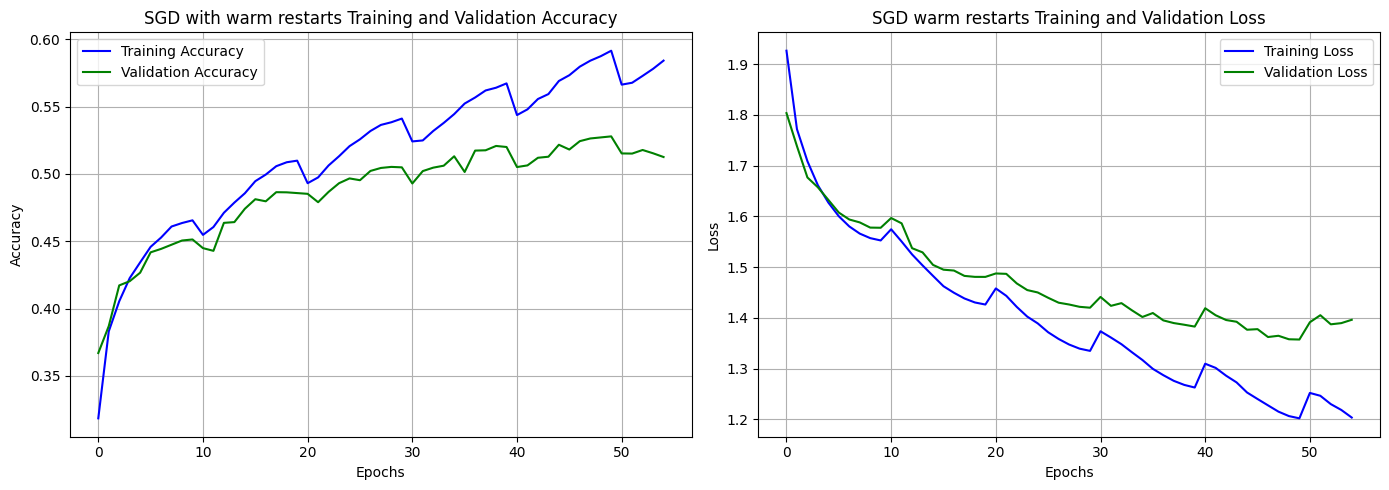

In [ ]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# Plot Training and Validation Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
axes[0].set_title('SGD with warm restarts Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# Plot Training and Validation Loss
axes[1].plot(history.history['loss'], label='Training Loss', color='blue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='green')
axes[1].set_title('SGD warm restarts Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

# Adjust layout and show plots
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy = modelSGD_WarmRestarts.evaluate(TestingImages, TestingLabels, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5132 - loss: 1.4006
Test Loss: 1.3948
Test Accuracy: 51.31%


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


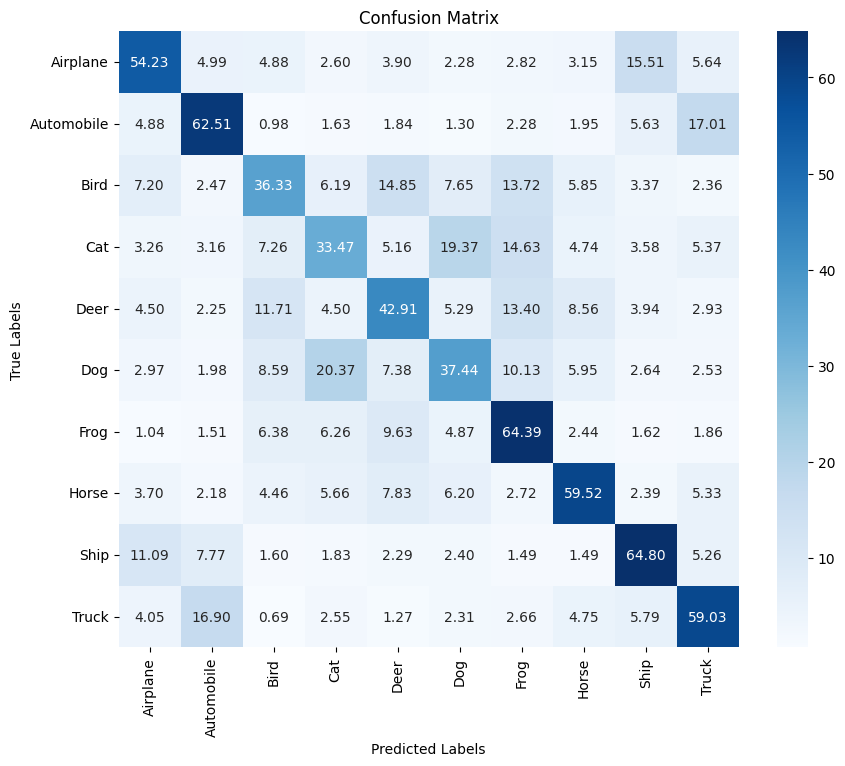

In [ ]:
PlotConfusionMatrix(modelSGD_WarmRestarts)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


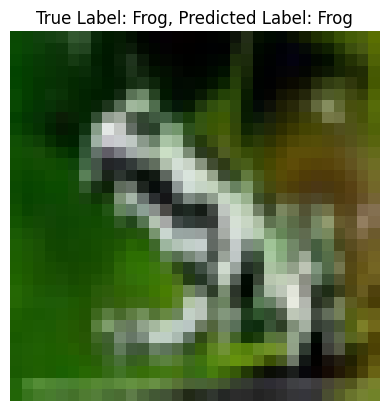

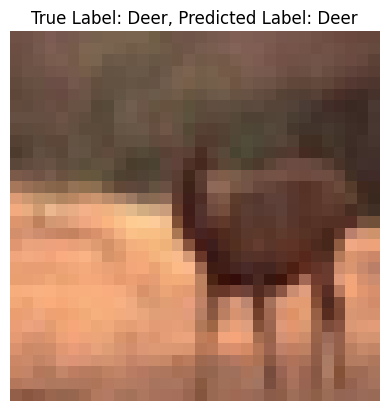

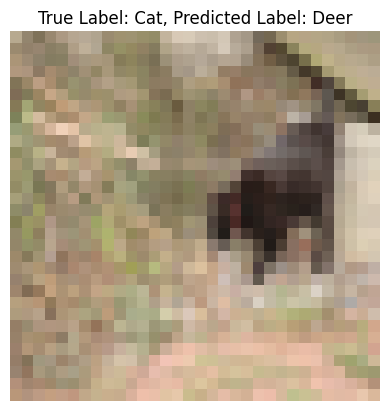

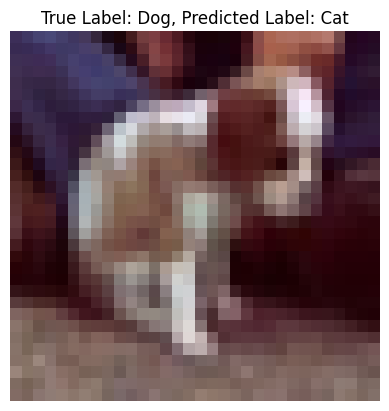

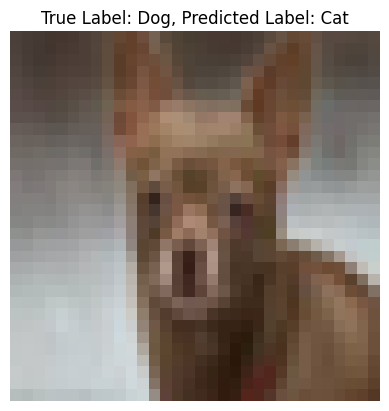

In [ ]:
samples = 10
predictions =  modelSGD_WarmRestarts.predict(TestingImages[:samples])
PrintTestSamples(TestingImages, TestingLabels, predictions)